# Homework Description
- English to Chinese (Traditional) Translation
  - Input: an English sentence         (e.g.		tom is a student .)
  - Output: the Chinese translation  (e.g. 		湯姆 是 個 學生 。)

- TODO
    - Train a simple RNN seq2seq to acheive translation
    - Switch to transformer model to boost performance
    - Apply Back-translation to furthur boost performance

In [1]:
!nvidia-smi

Tue Nov 22 21:55:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 526.86       Driver Version: 526.86       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:26:00.0  On |                  N/A |
| 42%   44C    P8    19W / 125W |   1164MiB /  6144MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Download and import required packages

In [ ]:
!pip install 'torch>=1.6.0' editdistance matplotlib sacrebleu sacremoses sentencepiece tqdm wandb
!pip install --upgrade jupyter ipywidgets

In [ ]:
!git clone https://github.com/pytorch/fairseq.git
!cd fairseq && git checkout 9a1c497
!pip install --upgrade ./fairseq/

In [2]:
import sys
import pdb
import pprint
import logging
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import numpy as np
import tqdm.auto as tqdm
from pathlib import Path
from argparse import Namespace
from fairseq import utils

import matplotlib.pyplot as plt

# Fix random seed

In [3]:
seed = 19961111
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
np.random.seed(seed)  
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Dataset

## En-Zh Bilingual Parallel Corpus
* [TED2020](#reimers-2020-multilingual-sentence-bert)
    - Raw: 398,066 (sentences)   
    - Processed: 393,980 (sentences)
    

## Testdata
- Size: 4,000 (sentences)
- **Chinese translation is undisclosed. The provided (.zh) file is psuedo translation, each line is a '。'**

## Dataset Download

data_dir = './DATA/rawdata'
dataset_name = 'ted2020'
urls = (
    "https://github.com/yuhsinchan/ML2022-HW5Dataset/releases/download/v1.0.2/ted2020.tgz",
    "https://github.com/yuhsinchan/ML2022-HW5Dataset/releases/download/v1.0.2/test.tgz",
)
file_names = (
    'ted2020.tgz', # train & dev
    'test.tgz', # test
)
prefix = Path(data_dir).absolute() / dataset_name

prefix.mkdir(parents=True, exist_ok=True)
for u, f in zip(urls, file_names):
    path = prefix/f
    if not path.exists():
        !wget {u} -O {path}
    if path.suffix == ".tgz":
        !tar -xvf {path} -C {prefix}
    elif path.suffix == ".zip":
        !unzip -o {path} -d {prefix}
!mv {prefix/'raw.en'} {prefix/'train_dev.raw.en'}
!mv {prefix/'raw.zh'} {prefix/'train_dev.raw.zh'}
!mv {prefix/'test/test.en'} {prefix/'test.raw.en'}
!mv {prefix/'test/test.zh'} {prefix/'test.raw.zh'}
!rm -rf {prefix/'test'}

## Language

In [4]:
data_dir = './DATA/rawdata'
dataset_name = 'ted2020'
prefix = Path(data_dir).absolute() / dataset_name

src_lang = 'en'
tgt_lang = 'zh'

data_prefix = f'{prefix}/train_dev.raw'
test_prefix = f'{prefix}/test.raw'
data_prefix, test_prefix

('E:\\project\\python\\ml_pratice\\DATA\\rawdata\\ted2020/train_dev.raw',
 'E:\\project\\python\\ml_pratice\\DATA\\rawdata\\ted2020/test.raw')

In [5]:
!head {data_prefix+'.'+src_lang} -n 5
!head {data_prefix+'.'+tgt_lang} -n 5

Thank you so much, Chris.
And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.
I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night.
And I say that sincerely, partly because  I need that.
Put yourselves in my position.
闈炲父璎濊瑵浣狅紝鍏嬮噷鏂�銆傝兘鏈夐�欏�嬫�熸渻绗�浜屽害韪忎笂閫欏�嬫紨璎涘彴
鐪熸槸涓�澶фΞ骞搞�傛垜闈炲父鎰熸縺銆�
閫欏�嬬爺瑷庢渻绲︽垜鐣欎笅浜嗘サ鐐烘繁鍒荤殑鍗拌薄锛屾垜鎯虫劅璎濆ぇ瀹� 灏嶆垜涔嬪墠婕旇瑳鐨勫ソ瑭曘��
鎴戞槸鐢辫》鐨勬兂閫欓杭瑾�锛屾湁閮ㄤ唤鍘熷洜鏄�鍥犵偤 鈥斺�� 鎴戠湡鐨勬湁闇�瑕�!
璜嬩綘鍊戣ō韬�铏曞湴鐐烘垜鎯充竴鎯筹紒


## Preprocess files

In [6]:
import re

def strQ2B(ustring):
    """Full width -> half width"""
    # reference:https://ithelp.ithome.com.tw/articles/10233122
    ss = []
    for s in ustring:
        rstring = ""
        for uchar in s:
            inside_code = ord(uchar)
            if inside_code == 12288:  # Full width space: direct conversion
                inside_code = 32
            elif (inside_code >= 65281 and inside_code <= 65374):  # Full width chars (except space) conversion
                inside_code -= 65248
            rstring += chr(inside_code)
        ss.append(rstring)
    return ''.join(ss)
                
def clean_s(s, lang):
    if lang == 'en':
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace('-', '') # remove '-'
        s = re.sub('([.,;!?()\"])', r' \1 ', s) # keep punctuation
    elif lang == 'zh':
        s = strQ2B(s) # Q2B
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace(' ', '')
        s = s.replace('—', '')
        s = s.replace('“', '"')
        s = s.replace('”', '"')
        s = s.replace('_', '')
        s = re.sub('([。,;!?()\"~「」])', r' \1 ', s) # keep punctuation
    s = ' '.join(s.strip().split())
    return s

def len_s(s, lang):
    if lang == 'zh':
        return len(s)
    return len(s.split())

def clean_corpus(prefix, l1, l2, ratio=9, max_len=1000, min_len=1):
    if Path(f'{prefix}.clean.{l1}').exists() and Path(f'{prefix}.clean.{l2}').exists():
        print(f'{prefix}.clean.{l1} & {l2} exists. skipping clean.')
        return
    with open(f'{prefix}.{l1}', 'r', encoding = 'utf-8') as l1_in_f:
        with open(f'{prefix}.{l2}', 'r', encoding = 'utf-8') as l2_in_f:
            with open(f'{prefix}.clean.{l1}', 'w', encoding = 'utf-8') as l1_out_f:
                with open(f'{prefix}.clean.{l2}', 'w', encoding = 'utf-8') as l2_out_f:
                    for s1 in l1_in_f:
                        s1 = s1.strip()
                        s2 = l2_in_f.readline().strip()
                        s1 = clean_s(s1, l1)
                        s2 = clean_s(s2, l2)
                        s1_len = len_s(s1, l1)
                        s2_len = len_s(s2, l2)
                        if min_len > 0: # remove short sentence
                            if s1_len < min_len or s2_len < min_len:
                                continue
                        if max_len > 0: # remove long sentence
                            if s1_len > max_len or s2_len > max_len:
                                continue
                        if ratio > 0: # remove by ratio of length
                            if s1_len/s2_len > ratio or s2_len/s1_len > ratio:
                                continue
                        print(s1, file=l1_out_f)
                        print(s2, file=l2_out_f)

In [7]:
clean_corpus(data_prefix, src_lang, tgt_lang)
clean_corpus(test_prefix, src_lang, tgt_lang, ratio=-1, min_len=-1, max_len=-1)

E:\project\python\ml_pratice\DATA\rawdata\ted2020/train_dev.raw.clean.en & zh exists. skipping clean.
E:\project\python\ml_pratice\DATA\rawdata\ted2020/test.raw.clean.en & zh exists. skipping clean.


In [8]:
!head {data_prefix+'.clean.'+src_lang} -n 5
!head {data_prefix+'.clean.'+tgt_lang} -n 5

Thank you so much , Chris .
And it's truly a great honor to have the opportunity to come to this stage twice ; I'm extremely grateful .
I have been blown away by this conference , and I want to thank all of you for the many nice comments about what I had to say the other night .
And I say that sincerely , partly because I need that .
Put yourselves in my position .
闈炲父璎濊瑵浣� , 鍏嬮噷鏂� 銆� 鑳芥湁閫欏�嬫�熸渻绗�浜屽害韪忎笂閫欏�嬫紨璎涘彴
鐪熸槸涓�澶фΞ骞� 銆� 鎴戦潪甯告劅婵� 銆�
閫欏�嬬爺瑷庢渻绲︽垜鐣欎笅浜嗘サ鐐烘繁鍒荤殑鍗拌薄 , 鎴戞兂鎰熻瑵澶у�跺皪鎴戜箣鍓嶆紨璎涚殑濂借�� 銆�
鎴戞槸鐢辫》鐨勬兂閫欓杭瑾� , 鏈夐儴浠藉師鍥犳槸鍥犵偤鎴戠湡鐨勬湁闇�瑕� !
璜嬩綘鍊戣ō韬�铏曞湴鐐烘垜鎯充竴鎯� !


## Split into train/valid

In [9]:
valid_ratio = 0.01 # 3000~4000 would suffice
train_ratio = 1 - valid_ratio

In [10]:
if (prefix/f'train.clean.{src_lang}').exists() \
and (prefix/f'train.clean.{tgt_lang}').exists() \
and (prefix/f'valid.clean.{src_lang}').exists() \
and (prefix/f'valid.clean.{tgt_lang}').exists():
    print(f'train/valid splits exists. skipping split.')
else:
    line_num = sum(1 for line in open(f'{data_prefix}.clean.{src_lang}', encoding = 'utf-8'))
    labels = list(range(line_num))
    random.shuffle(labels)
    for lang in [src_lang, tgt_lang]:
        train_f = open(os.path.join(data_dir, dataset_name, f'train.clean.{lang}'), 'w', encoding = 'utf-8')
        valid_f = open(os.path.join(data_dir, dataset_name, f'valid.clean.{lang}'), 'w', encoding = 'utf-8')
        count = 0
        for line in open(f'{data_prefix}.clean.{lang}', 'r', encoding = 'utf-8'):
            if labels[count]/line_num < train_ratio:
                train_f.write(line)
            else:
                valid_f.write(line)
            count += 1
        train_f.close()
        valid_f.close()

train/valid splits exists. skipping split.


## Subword Units 
Out of vocabulary (OOV) has been a major problem in machine translation. This can be alleviated by using subword units.
- We will use the [sentencepiece](#kudo-richardson-2018-sentencepiece) package
- select 'unigram' or 'byte-pair encoding (BPE)' algorithm

In [11]:
import sentencepiece as spm
vocab_size = 8000
if (prefix/f'spm{vocab_size}.model').exists():
    print(f'{prefix}/spm{vocab_size}.model exists. skipping spm_train.')
else:
    spm.SentencePieceTrainer.train(
        input=','.join([f'{prefix}/train.clean.{src_lang}',
                        f'{prefix}/valid.clean.{src_lang}',
                        f'{prefix}/train.clean.{tgt_lang}',
                        f'{prefix}/valid.clean.{tgt_lang}']),
        model_prefix=prefix/f'spm{vocab_size}',
        vocab_size=vocab_size,
        character_coverage=1,
        model_type='unigram', # 'bpe' works as well
        input_sentence_size=1e6,
        shuffle_input_sentence=True,
        normalization_rule_name='nmt_nfkc_cf',
    )

E:\project\python\ml_pratice\DATA\rawdata\ted2020/spm8000.model exists. skipping spm_train.


In [12]:
spm_model = spm.SentencePieceProcessor(model_file=str(prefix/f'spm{vocab_size}.model'))
in_tag = {
    'train': 'train.clean',
    'valid': 'valid.clean',
    'test': 'test.raw.clean',
}
for split in ['train', 'valid', 'test']:
    for lang in [src_lang, tgt_lang]:
        out_path = prefix/f'{split}.{lang}'
        if out_path.exists():
            print(f"{out_path} exists. skipping spm_encode.")
        else:
            with open(prefix/f'{split}.{lang}', 'w', encoding = 'utf-8') as out_f:
                with open(prefix/f'{in_tag[split]}.{lang}', 'r', encoding = 'utf-8') as in_f:
                    for line in in_f:
                        line = line.strip()
                        tok = spm_model.encode(line, out_type=str)
                        print(' '.join(tok), file=out_f)

E:\project\python\ml_pratice\DATA\rawdata\ted2020\train.en exists. skipping spm_encode.
E:\project\python\ml_pratice\DATA\rawdata\ted2020\train.zh exists. skipping spm_encode.
E:\project\python\ml_pratice\DATA\rawdata\ted2020\valid.en exists. skipping spm_encode.
E:\project\python\ml_pratice\DATA\rawdata\ted2020\valid.zh exists. skipping spm_encode.
E:\project\python\ml_pratice\DATA\rawdata\ted2020\test.en exists. skipping spm_encode.
E:\project\python\ml_pratice\DATA\rawdata\ted2020\test.zh exists. skipping spm_encode.


In [13]:
!head {data_dir+'/'+dataset_name+'/train.'+src_lang} -n 5
!head {data_dir+'/'+dataset_name+'/train.'+tgt_lang} -n 5

鈻乼hank 鈻亂ou 鈻乻o 鈻乵uch 鈻�, 鈻乧hris 鈻�.
鈻乤nd 鈻乮t ' s 鈻� t ru ly 鈻乤 鈻乬reat 鈻乭o n or 鈻乼o 鈻乭ave 鈻乼he 鈻� op port un ity 鈻乼o 鈻乧ome 鈻乼o 鈻乼his 鈻乻t age 鈻� t wi ce 鈻�; 鈻乮 ' m 鈻乪x t re me ly 鈻乬r ate ful 鈻�.
鈻乮 鈻乭ave 鈻乥een 鈻� bl ow n 鈻乤way 鈻乥y 鈻乼his 鈻乧on fer ence 鈻�, 鈻乤nd 鈻乮 鈻亀ant 鈻乼o 鈻乼hank 鈻乤ll 鈻乷f 鈻亂ou 鈻乫or 鈻乼he 鈻乵any 鈻� ni ce 鈻� com ment s 鈻乤bout 鈻亀hat 鈻乮 鈻乭ad 鈻乼o 鈻乻ay 鈻乼he 鈻乷ther 鈻乶ight 鈻�.
鈻乤nd 鈻乮 鈻乻ay 鈻乼hat 鈻乻ince re ly 鈻�, 鈻乸art ly 鈻乥ecause 鈻乮 鈻乶eed 鈻乼hat 鈻�.
鈻乸ut 鈻亂our s el ve s 鈻乮n 鈻乵y 鈻乸o s ition 鈻�.
鈻� 闈炲父 璎� 璎� 浣� 鈻�, 鈻� 鍏� 閲� 鏂� 鈻併�� 鈻� 鑳� 鏈� 閫欏�� 姗熸渻 绗�浜� 搴� 韪� 涓� 閫欏�� 婕旇瑳 鍙�
鈻� 鐪� 鏄� 涓� 澶� 姒� 骞� 鈻併�� 鈻佹垜 闈炲父 鎰� 婵� 鈻併��
鈻侀�欏�� 鐮� 瑷� 鏈� 绲︽垜 鐣� 涓� 浜� 妤� 鐐� 娣� 鍒� 鐨� 鍗� 璞� 鈻�, 鈻佹垜鎯� 鎰� 璎� 澶у�� 灏嶆垜 涔嬪墠 婕旇瑳 鐨� 濂� 瑭� 鈻併��
鈻佹垜 鏄�鐢� 琛� 鐨� 鎯� 閫欓杭 瑾� 鈻�, 鈻佹湁 閮ㄤ唤 鍘熷洜 鏄�鍥犵偤 鎴� 鐪熺殑 鏈� 闇�瑕� 鈻�!
鈻� 璜� 浣犲�� 瑷� 韬� 铏� 鍦� 鐐� 鎴戞兂 涓� 鎯� 鈻�!


## Binarize the data with fairseq

In [14]:
binpath = Path('./DATA/data-bin', dataset_name)
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess \
        --source-lang {src_lang}\
        --target-lang {tgt_lang}\
        --trainpref {prefix/'train'}\
        --validpref {prefix/'valid'}\
        --testpref {prefix/'test'}\
        --destdir {binpath}\
        --joined-dictionary\
        --workers 8

DATA\data-bin\ted2020 exists, will not overwrite!


# Configuration for experiments

In [15]:
config = Namespace(
    datadir = "./DATA/data-bin/ted2020",
    savedir = "./checkpoints/rnn",
    source_lang = "en",
    target_lang = "zh",
    
    # cpu threads when fetching & processing data.
    num_workers=8,  
    # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
    max_tokens=8192,
    accum_steps=2,
    
    # the lr s calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
    lr_factor=2.,
    lr_warmup=4000,
    
    # clipping gradient norm helps alleviate gradient exploding
    clip_norm=1.0,
    
    # maximum epochs for training
    max_epoch=30,
    start_epoch=1,
    
    # beam size for beam search
    beam=5, 
    # generate sequences of maximum length ax + b, where x is the source length
    max_len_a=1.2, 
    max_len_b=10, 
    # when decoding, post process sentence by removing sentencepiece symbols and jieba tokenization.
    post_process = "sentencepiece",
    
    # checkpoints
    keep_last_epochs=5,
    resume=None, # if resume from checkpoint name (under config.savedir)
    
    # logging
    use_wandb=False,
)

# Logging
- logging package logs ordinary messages
- wandb logs the loss, bleu, etc. in the training process

In [16]:
logging.basicConfig(
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level="INFO", # "DEBUG" "WARNING" "ERROR"
    stream=sys.stdout,
)
proj = "hw5.seq2seq"
logger = logging.getLogger(proj)
if config.use_wandb:
    import wandb
    wandb.init(project=proj, name=Path(config.savedir).stem, config=config)

# CUDA Environments

In [17]:
cuda_env = utils.CudaEnvironment()
utils.CudaEnvironment.pretty_print_cuda_env_list([cuda_env])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

2022-11-26 09:37:18 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************
2022-11-26 09:37:18 | INFO | fairseq.utils | rank   0: capabilities =  7.5  ; total memory = 6.000 GB ; name = NVIDIA GeForce GTX 1660 SUPER           
2022-11-26 09:37:18 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************


# Dataloading

## We borrow the TranslationTask from fairseq
* used to load the binarized data created above
* well-implemented data iterator (dataloader)
* built-in task.source_dictionary and task.target_dictionary are also handy
* well-implemented beach search decoder

In [18]:
from fairseq.tasks.translation import TranslationConfig, TranslationTask

## setup task
task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

2022-11-26 09:37:18 | INFO | fairseq.tasks.translation | [en] dictionary: 8000 types
2022-11-26 09:37:18 | INFO | fairseq.tasks.translation | [zh] dictionary: 8000 types


In [19]:
logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

2022-11-26 09:37:19 | INFO | hw5.seq2seq | loading data for epoch 1
2022-11-26 09:37:19 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020\train.en-zh.en
2022-11-26 09:37:19 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020\train.en-zh.zh
2022-11-26 09:37:19 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 train en-zh 390041 examples
2022-11-26 09:37:19 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020\valid.en-zh.en
2022-11-26 09:37:19 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020\valid.en-zh.zh
2022-11-26 09:37:19 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 valid en-zh 3939 examples


In [20]:
sample = task.dataset("valid")[1]
pprint.pprint(sample)
pprint.pprint(
    "Source: " + \
    task.source_dictionary.string(
        sample['source'],
        config.post_process,
    )
)
pprint.pprint(
    "Target: " + \
    task.target_dictionary.string(
        sample['target'],
        config.post_process,
    )
)

{'id': 1,
 'source': tensor([2035,   14,   16,   18,  620,  345,    8,  497,   16,  785,    8,  377,
        1635,   29,   33,    2]),
 'target': tensor([ 140,  317,  463, 3314, 2876, 1102,  433,   33,    2])}
"Source: isn't that putting the cart before the horse ?"
'Target: 這不是本末倒置嗎 ?'


# Dataset iterator

* Controls every batch to contain no more than N tokens, which optimizes GPU memory efficiency
* Shuffles the training set for every epoch
* Ignore sentences exceeding maximum length
* Pad all sentences in a batch to the same length, which enables parallel computing by GPU
* Add eos and shift one token
    - teacher forcing: to train the model to predict the next token based on prefix, we feed the right shifted target sequence as the decoder input.
    - generally, prepending bos to the target would do the job (as shown below)
![seq2seq](https://i.imgur.com/0zeDyuI.png)
    - in fairseq however, this is done by moving the eos token to the begining. Empirically, this has the same effect. For instance:
    ```
    # output target (target) and Decoder input (prev_output_tokens): 
                   eos = 2
                target = 419,  711,  238,  888,  792,   60,  968,    8,    2
    prev_output_tokens = 2,  419,  711,  238,  888,  792,   60,  968,    8
    ```



In [21]:
def load_data_iterator(task, split, epoch=1, max_tokens=4000, num_workers=1, cached=True):
    batch_iterator = task.get_batch_iterator(
        dataset=task.dataset(split),
        max_tokens=max_tokens,
        max_sentences=None,
        max_positions=utils.resolve_max_positions(
            task.max_positions(),
            max_tokens,
        ),
        ignore_invalid_inputs=True,
        seed=seed,
        num_workers=num_workers,
        epoch=epoch,
        disable_iterator_cache=not cached,
        # Set this to False to speed up. However, if set to False, changing max_tokens beyond 
        # first call of this method has no effect. 
    )
    return batch_iterator

demo_epoch_obj = load_data_iterator(task, "valid", epoch=1, max_tokens=20, num_workers=1, cached=False)
demo_iter = demo_epoch_obj.next_epoch_itr(shuffle=True)
sample = next(demo_iter)
sample

2022-11-26 09:37:21 | WARNING | fairseq.tasks.fairseq_task | 2,606 samples have invalid sizes and will be skipped, max_positions=(20, 20), first few sample ids=[2612, 2278, 3157, 2967, 750, 2254, 3582, 427, 3376, 3741]


{'id': tensor([806]),
 'nsentences': 1,
 'ntokens': 16,
 'net_input': {'src_tokens': tensor([[ 22,  14,  71, 276, 714, 500,   8, 330, 471, 113,   8, 701, 358, 471,
             7,   2]]),
  'src_lengths': tensor([16]),
  'prev_output_tokens': tensor([[   2,   53,  437,  190,  402, 3440,  154,   67, 2317, 3440,  154,  125,
            300,  359,   34,   10]])},
 'target': tensor([[  53,  437,  190,  402, 3440,  154,   67, 2317, 3440,  154,  125,  300,
           359,   34,   10,    2]])}

* each batch is a python dict, with string key and Tensor value. Contents are described below:
```python
batch = {
    "id": id, # id for each example 
    "nsentences": len(samples), # batch size (sentences)
    "ntokens": ntokens, # batch size (tokens)
    "net_input": {
        "src_tokens": src_tokens, # sequence in source language
        "src_lengths": src_lengths, # sequence length of each example before padding
        "prev_output_tokens": prev_output_tokens, # right shifted target, as mentioned above.
    },
    "target": target, # target sequence
}
```

# Model Architecture
* We again inherit fairseq's encoder, decoder and model, so that in the testing phase we can directly leverage fairseq's beam search decoder.

In [22]:
from fairseq.models import (
    FairseqEncoder, 
    FairseqIncrementalDecoder,
    FairseqEncoderDecoderModel
)

# Encoder

- The Encoder is a RNN or Transformer Encoder. The following description is for RNN. For every input token, Encoder will generate a output vector and a hidden states vector, and the hidden states vector is passed on to the next step. In other words, the Encoder sequentially reads in the input sequence, and outputs a single vector at each timestep, then finally outputs the final hidden states, or content vector, at the last timestep.
- Parameters:
  - *args*
      - encoder_embed_dim: the dimension of embeddings, this compresses the one-hot vector into fixed dimensions, which achieves dimension reduction
      - encoder_ffn_embed_dim is the dimension of hidden states and output vectors
      - encoder_layers is the number of layers for Encoder RNN
      - dropout determines the probability of a neuron's activation being set to 0, in order to prevent overfitting. Generally this is applied in training, and removed in testing.
  - *dictionary*: the dictionary provided by fairseq. it's used to obtain the padding index, and in turn the encoder padding mask. 
  - *embed_tokens*: an instance of token embeddings (nn.Embedding)

- Inputs: 
    - *src_tokens*: integer sequence representing english e.g. 1, 28, 29, 205, 2 
- Outputs: 
    - *outputs*: the output of RNN at each timestep, can be furthur processed by Attention
    - *final_hiddens*: the hidden states of each timestep, will be passed to decoder for decoding
    - *encoder_padding_mask*: this tells the decoder which position to ignore


In [23]:
class RNNEncoder(FairseqEncoder):
    def __init__(self, args, dictionary, embed_tokens):
        super().__init__(dictionary)
        self.embed_tokens = embed_tokens
        
        self.embed_dim = args.encoder_embed_dim
        self.hidden_dim = args.encoder_ffn_embed_dim
        self.num_layers = args.encoder_layers
        
        self.dropout_in_module = nn.Dropout(args.dropout)
        self.rnn = nn.GRU(
            self.embed_dim, 
            self.hidden_dim, 
            self.num_layers, 
            dropout=args.dropout, 
            batch_first=False, 
            bidirectional=True
        )
        self.dropout_out_module = nn.Dropout(args.dropout)
        
        self.padding_idx = dictionary.pad()
        
    def combine_bidir(self, outs, bsz: int):
        out = outs.view(self.num_layers, 2, bsz, -1).transpose(1, 2).contiguous()
        return out.view(self.num_layers, bsz, -1)

    def forward(self, src_tokens, **unused):
        bsz, seqlen = src_tokens.size()
        
        # get embeddings
        x = self.embed_tokens(src_tokens)
        x = self.dropout_in_module(x)

        # B x T x C -> T x B x C
        x = x.transpose(0, 1)
        
        # pass thru bidirectional RNN
        h0 = x.new_zeros(2 * self.num_layers, bsz, self.hidden_dim)
        x, final_hiddens = self.rnn(x, h0)
        outputs = self.dropout_out_module(x)
        # outputs = [sequence len, batch size, hid dim * directions]
        # hidden =  [num_layers * directions, batch size  , hid dim]
        
        # Since Encoder is bidirectional, we need to concatenate the hidden states of two directions
        final_hiddens = self.combine_bidir(final_hiddens, bsz)
        # hidden =  [num_layers x batch x num_directions*hidden]
        
        encoder_padding_mask = src_tokens.eq(self.padding_idx).t()
        return tuple(
            (
                outputs,  # seq_len x batch x hidden
                final_hiddens,  # num_layers x batch x num_directions*hidden
                encoder_padding_mask,  # seq_len x batch
            )
        )
    
    def reorder_encoder_out(self, encoder_out, new_order):
        # This is used by fairseq's beam search. How and why is not particularly important here.
        return tuple(
            (
                encoder_out[0].index_select(1, new_order),
                encoder_out[1].index_select(1, new_order),
                encoder_out[2].index_select(1, new_order),
            )
        )

## Attention

- When the input sequence is long, "content vector" alone cannot accurately represent the whole sequence, attention mechanism can provide the Decoder more information.
- According to the **Decoder embeddings** of the current timestep, match the **Encoder outputs** with decoder embeddings to determine correlation, and then sum the Encoder outputs weighted by the correlation as the input to **Decoder** RNN.
- Common attention implementations use neural network / dot product as the correlation between **query** (decoder embeddings) and **key** (Encoder outputs), followed by **softmax**  to obtain a distribution, and finally **values** (Encoder outputs) is **weighted sum**-ed by said distribution.

- Parameters:
  - *input_embed_dim*: dimensionality of key, should be that of the vector in decoder to attend others
  - *source_embed_dim*: dimensionality of query, should be that of the vector to be attended to (encoder outputs)
  - *output_embed_dim*: dimensionality of value, should be that of the vector after attention, expected by the next layer

- Inputs: 
    - *inputs*: is the key, the vector to attend to others
    - *encoder_outputs*:  is the query/value, the vector to be attended to
    - *encoder_padding_mask*: this tells the decoder which position to ignore
- Outputs: 
    - *output*: the context vector after attention
    - *attention score*: the attention distribution


In [24]:
class AttentionLayer(nn.Module):
    def __init__(self, input_embed_dim, source_embed_dim, output_embed_dim, bias=False):
        super().__init__()

        self.input_proj = nn.Linear(input_embed_dim, source_embed_dim, bias=bias)
        self.output_proj = nn.Linear(
            input_embed_dim + source_embed_dim, output_embed_dim, bias=bias
        )

    def forward(self, inputs, encoder_outputs, encoder_padding_mask):
        # inputs: T, B, dim
        # encoder_outputs: S x B x dim
        # padding mask:  S x B
        
        # convert all to batch first
        inputs = inputs.transpose(1,0) # B, T, dim
        encoder_outputs = encoder_outputs.transpose(1,0) # B, S, dim
        encoder_padding_mask = encoder_padding_mask.transpose(1,0) # B, S
        
        # project to the dimensionality of encoder_outputs
        x = self.input_proj(inputs)

        # compute attention
        # (B, T, dim) x (B, dim, S) = (B, T, S)
        attn_scores = torch.bmm(x, encoder_outputs.transpose(1,2))

        # cancel the attention at positions corresponding to padding
        if encoder_padding_mask is not None:
            # leveraging broadcast  B, S -> (B, 1, S)
            encoder_padding_mask = encoder_padding_mask.unsqueeze(1)
            attn_scores = (
                attn_scores.float()
                .masked_fill_(encoder_padding_mask, float("-inf"))
                .type_as(attn_scores)
            )  # FP16 support: cast to float and back

        # softmax on the dimension corresponding to source sequence
        attn_scores = F.softmax(attn_scores, dim=-1)

        # shape (B, T, S) x (B, S, dim) = (B, T, dim) weighted sum
        x = torch.bmm(attn_scores, encoder_outputs)

        # (B, T, dim)
        x = torch.cat((x, inputs), dim=-1)
        x = torch.tanh(self.output_proj(x)) # concat + linear + tanh
        
        # restore shape (B, T, dim) -> (T, B, dim)
        return x.transpose(1,0), attn_scores

# Decoder

* The hidden states of **Decoder** will be initialized by the final hidden states of **Encoder** (the content vector)
* At the same time, **Decoder** will change its hidden states based on the input of the current timestep (the outputs of previous timesteps), and generates an output
* Attention improves the performance
* The seq2seq steps are implemented in decoder, so that later the Seq2Seq class can accept RNN and Transformer, without furthur modification.
- Parameters:
  - *args*
      - decoder_embed_dim: is the dimensionality of the decoder embeddings, similar to encoder_embed_dim，
      - decoder_ffn_embed_dim: is the dimensionality of the decoder RNN hidden states, similar to encoder_ffn_embed_dim
      - decoder_layers: number of layers of RNN decoder
      - share_decoder_input_output_embed: usually, the projection matrix of the decoder will share weights with the decoder input embeddings
  - *dictionary*: the dictionary provided by fairseq
  - *embed_tokens*: an instance of token embeddings (nn.Embedding)
- Inputs: 
    - *prev_output_tokens*: integer sequence representing the right-shifted target e.g. 1, 28, 29, 205, 2 
    - *encoder_out*: encoder's output.
    - *incremental_state*: in order to speed up decoding during test time, we will save the hidden state of each timestep. see forward() for details.
- Outputs: 
    - *outputs*: the logits (before softmax) output of decoder for each timesteps
    - *extra*: unsused

In [25]:
class RNNDecoder(FairseqIncrementalDecoder):
    def __init__(self, args, dictionary, embed_tokens):
        super().__init__(dictionary)
        self.embed_tokens = embed_tokens
        
        assert args.decoder_layers == args.encoder_layers, f"""seq2seq rnn requires that encoder 
        and decoder have same layers of rnn. got: {args.encoder_layers, args.decoder_layers}"""
        assert args.decoder_ffn_embed_dim == args.encoder_ffn_embed_dim*2, f"""seq2seq-rnn requires 
        that decoder hidden to be 2*encoder hidden dim. got: {args.decoder_ffn_embed_dim, args.encoder_ffn_embed_dim*2}"""
        
        self.embed_dim = args.decoder_embed_dim
        self.hidden_dim = args.decoder_ffn_embed_dim
        self.num_layers = args.decoder_layers
        
        
        self.dropout_in_module = nn.Dropout(args.dropout)
        self.rnn = nn.GRU(
            self.embed_dim, 
            self.hidden_dim, 
            self.num_layers, 
            dropout=args.dropout, 
            batch_first=False, 
            bidirectional=False
        )
        self.attention = AttentionLayer(
            self.embed_dim, self.hidden_dim, self.embed_dim, bias=False
        ) 
        # self.attention = None
        self.dropout_out_module = nn.Dropout(args.dropout)
        
        if self.hidden_dim != self.embed_dim:
            self.project_out_dim = nn.Linear(self.hidden_dim, self.embed_dim)
        else:
            self.project_out_dim = None
        
        if args.share_decoder_input_output_embed:
            self.output_projection = nn.Linear(
                self.embed_tokens.weight.shape[1],
                self.embed_tokens.weight.shape[0],
                bias=False,
            )
            self.output_projection.weight = self.embed_tokens.weight
        else:
            self.output_projection = nn.Linear(
                self.output_embed_dim, len(dictionary), bias=False
            )
            nn.init.normal_(
                self.output_projection.weight, mean=0, std=self.output_embed_dim ** -0.5
            )
        
    def forward(self, prev_output_tokens, encoder_out, incremental_state=None, **unused):
        # extract the outputs from encoder
        encoder_outputs, encoder_hiddens, encoder_padding_mask = encoder_out
        # outputs:          seq_len x batch x num_directions*hidden
        # encoder_hiddens:  num_layers x batch x num_directions*encoder_hidden
        # padding_mask:     seq_len x batch
        
        if incremental_state is not None and len(incremental_state) > 0:
            # if the information from last timestep is retained, we can continue from there instead of starting from bos
            prev_output_tokens = prev_output_tokens[:, -1:]
            cache_state = self.get_incremental_state(incremental_state, "cached_state")
            prev_hiddens = cache_state["prev_hiddens"]
        else:
            # incremental state does not exist, either this is training time, or the first timestep of test time
            # prepare for seq2seq: pass the encoder_hidden to the decoder hidden states
            prev_hiddens = encoder_hiddens
        
        bsz, seqlen = prev_output_tokens.size()
        
        # embed tokens
        x = self.embed_tokens(prev_output_tokens)
        x = self.dropout_in_module(x)

        # B x T x C -> T x B x C
        x = x.transpose(0, 1)
                
        # decoder-to-encoder attention
        if self.attention is not None:
            x, attn = self.attention(x, encoder_outputs, encoder_padding_mask)
                        
        # pass thru unidirectional RNN
        x, final_hiddens = self.rnn(x, prev_hiddens)
        # outputs = [sequence len, batch size, hid dim]
        # hidden =  [num_layers * directions, batch size  , hid dim]
        x = self.dropout_out_module(x)
                
        # project to embedding size (if hidden differs from embed size, and share_embedding is True, 
        # we need to do an extra projection)
        if self.project_out_dim != None:
            x = self.project_out_dim(x)
        
        # project to vocab size
        x = self.output_projection(x)
        
        # T x B x C -> B x T x C
        x = x.transpose(1, 0)
        
        # if incremental, record the hidden states of current timestep, which will be restored in the next timestep
        cache_state = {
            "prev_hiddens": final_hiddens,
        }
        self.set_incremental_state(incremental_state, "cached_state", cache_state)
        
        return x, None
    
    def reorder_incremental_state(
        self,
        incremental_state,
        new_order,
    ):
        # This is used by fairseq's beam search. How and why is not particularly important here.
        cache_state = self.get_incremental_state(incremental_state, "cached_state")
        prev_hiddens = cache_state["prev_hiddens"]
        prev_hiddens = [p.index_select(0, new_order) for p in prev_hiddens]
        cache_state = {
            "prev_hiddens": torch.stack(prev_hiddens),
        }
        self.set_incremental_state(incremental_state, "cached_state", cache_state)
        return

## Seq2Seq
- Composed of **Encoder** and **Decoder**
- Recieves inputs and pass to **Encoder** 
- Pass the outputs from **Encoder** to **Decoder**
- **Decoder** will decode according to outputs of previous timesteps as well as **Encoder** outputs  
- Once done decoding, return the **Decoder** outputs

In [26]:
class Seq2Seq(FairseqEncoderDecoderModel):
    def __init__(self, args, encoder, decoder):
        super().__init__(encoder, decoder)
        self.args = args
    
    def forward(
        self,
        src_tokens,
        src_lengths,
        prev_output_tokens,
        return_all_hiddens: bool = True,
    ):
        """
        Run the forward pass for an encoder-decoder model.
        """
        encoder_out = self.encoder(
            src_tokens, src_lengths=src_lengths, return_all_hiddens=return_all_hiddens
        )
        logits, extra = self.decoder(
            prev_output_tokens,
            encoder_out=encoder_out,
            src_lengths=src_lengths,
            return_all_hiddens=return_all_hiddens,
        )
        return logits, extra

# Model Initialization

In [27]:
# # HINT: transformer architecture
from fairseq.models.transformer import (
    TransformerEncoder, 
    TransformerDecoder,
)

def build_model(args, task):
    """ build a model instance based on hyperparameters """
    src_dict, tgt_dict = task.source_dictionary, task.target_dictionary

    # token embeddings
    encoder_embed_tokens = nn.Embedding(len(src_dict), args.encoder_embed_dim, src_dict.pad())
    decoder_embed_tokens = nn.Embedding(len(tgt_dict), args.decoder_embed_dim, tgt_dict.pad())
    
    # encoder decoder
    # HINT: TODO: switch to TransformerEncoder & TransformerDecoder
#     encoder = RNNEncoder(args, src_dict, encoder_embed_tokens)
#     decoder = RNNDecoder(args, tgt_dict, decoder_embed_tokens)
    encoder = TransformerEncoder(args, src_dict, encoder_embed_tokens)
    decoder = TransformerDecoder(args, tgt_dict, decoder_embed_tokens)

    # sequence to sequence model
    model = Seq2Seq(args, encoder, decoder)
    
    # initialization for seq2seq model is important, requires extra handling
    def init_params(module):
        from fairseq.modules import MultiheadAttention
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        if isinstance(module, MultiheadAttention):
            module.q_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.k_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.v_proj.weight.data.normal_(mean=0.0, std=0.02)
        if isinstance(module, nn.RNNBase):
            for name, param in module.named_parameters():
                if "weight" in name or "bias" in name:
                    param.data.uniform_(-0.1, 0.1)
            
    # weight initialization
    model.apply(init_params)
    return model

## Architecture Related Configuration

For strong baseline, please refer to the hyperparameters for *transformer-base* in Table 3 in [Attention is all you need](#vaswani2017)

In [28]:
arch_args = Namespace(
    encoder_embed_dim=256,
    encoder_ffn_embed_dim=512,
    encoder_layers=4,
    decoder_embed_dim=256,
    decoder_ffn_embed_dim=1024,
    decoder_layers=4,
    share_decoder_input_output_embed=True,
    dropout=0.3,
)

# HINT: these patches on parameters for Transformer
def add_transformer_args(args):
    args.encoder_attention_heads=4
    args.encoder_normalize_before=True
    
    args.decoder_attention_heads=4
    args.decoder_normalize_before=True
    
    args.activation_fn="relu"
    args.max_source_positions=1024
    args.max_target_positions=1024
    
    # patches on default parameters for Transformer (those not set above)
    from fairseq.models.transformer import base_architecture
    base_architecture(arch_args)

add_transformer_args(arch_args)

In [29]:
if config.use_wandb:
    wandb.config.update(vars(arch_args))

In [30]:
model = build_model(arch_args, task)
logger.info(model)

2022-11-26 09:37:25 | INFO | hw5.seq2seq | Seq2Seq(
  (encoder): TransformerEncoder(
    (dropout_module): FairseqDropout()
    (embed_tokens): Embedding(8000, 256, padding_idx=1)
    (embed_positions): SinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0): TransformerEncoderLayerBase(
        (self_attn): MultiheadAttention(
          (dropout_module): FairseqDropout()
          (k_proj): Linear(in_features=256, out_features=256, bias=True)
          (v_proj): Linear(in_features=256, out_features=256, bias=True)
          (q_proj): Linear(in_features=256, out_features=256, bias=True)
          (out_proj): Linear(in_features=256, out_features=256, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout_module): FairseqDropout()
        (activation_dropout_module): FairseqDropout()
        (fc1): Linear(in_features=256, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=256, b

# Optimization

## Loss: Label Smoothing Regularization
* let the model learn to generate less concentrated distribution, and prevent over-confidence
* sometimes the ground truth may not be the only answer. thus, when calculating loss, we reserve some probability for incorrect labels
* avoids overfitting

code [source](https://fairseq.readthedocs.io/en/latest/_modules/fairseq/criterions/label_smoothed_cross_entropy.html)

In [31]:
class LabelSmoothedCrossEntropyCriterion(nn.Module):
    def __init__(self, smoothing, ignore_index=None, reduce=True):
        super().__init__()
        self.smoothing = smoothing
        self.ignore_index = ignore_index
        self.reduce = reduce
    
    def forward(self, lprobs, target):
        if target.dim() == lprobs.dim() - 1:
            target = target.unsqueeze(-1)
        # nll: Negative log likelihood，the cross-entropy when target is one-hot. following line is same as F.nll_loss
        nll_loss = -lprobs.gather(dim=-1, index=target)
        #  reserve some probability for other labels. thus when calculating cross-entropy, 
        # equivalent to summing the log probs of all labels
        smooth_loss = -lprobs.sum(dim=-1, keepdim=True)
        if self.ignore_index is not None:
            pad_mask = target.eq(self.ignore_index)
            nll_loss.masked_fill_(pad_mask, 0.0)
            smooth_loss.masked_fill_(pad_mask, 0.0)
        else:
            nll_loss = nll_loss.squeeze(-1)
            smooth_loss = smooth_loss.squeeze(-1)
        if self.reduce:
            nll_loss = nll_loss.sum()
            smooth_loss = smooth_loss.sum()
        # when calculating cross-entropy, add the loss of other labels
        eps_i = self.smoothing / lprobs.size(-1)
        loss = (1.0 - self.smoothing) * nll_loss + eps_i * smooth_loss
        return loss

# generally, 0.1 is good enough
criterion = LabelSmoothedCrossEntropyCriterion(
    smoothing=0.1,
    ignore_index=task.target_dictionary.pad(),
)

## Optimizer: Adam + lr scheduling
Inverse square root scheduling is important to the stability when training Transformer. It's later used on RNN as well.
Update the learning rate according to the following equation. Linearly increase the first stage, then decay proportionally to the inverse square root of timestep.
$$lrate = d_{\text{model}}^{-0.5}\cdot\min({step\_num}^{-0.5},{step\_num}\cdot{warmup\_steps}^{-1.5})$$

In [32]:
def get_rate(d_model, step_num, warmup_step):
    # TODO: Change lr from constant to the equation shown above
#     lr = 0.001
    lr = np.power(d_model, -0.5) * min(np.power(step_num, -0.5), step_num * np.power(warmup_step, -1.5))
    return lr

In [33]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
    
    @property
    def param_groups(self):
        return self.optimizer.param_groups
        
    def multiply_grads(self, c):
        """Multiplies grads by a constant *c*."""                
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.grad.data.mul_(c)
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return 0 if not step else self.factor * get_rate(self.model_size, step, self.warmup)

## Scheduling Visualized

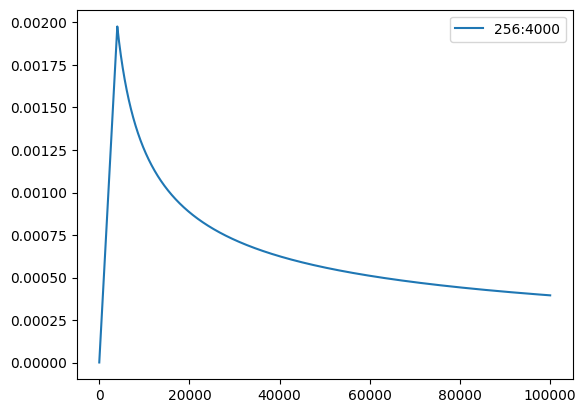

In [34]:
optimizer = NoamOpt(
    model_size=arch_args.encoder_embed_dim, 
    factor=config.lr_factor, 
    warmup=config.lr_warmup, 
    optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001))
plt.plot(np.arange(1, 100000), [optimizer.rate(i) for i in range(1, 100000)])
plt.legend([f"{optimizer.model_size}:{optimizer.warmup}"])
None

# Training Procedure

## Training

In [35]:
from fairseq.data import iterators
from torch.cuda.amp import GradScaler, autocast

def train_one_epoch(epoch_itr, model, task, criterion, optimizer, accum_steps=1):
    itr = epoch_itr.next_epoch_itr(shuffle=True)
    itr = iterators.GroupedIterator(itr, accum_steps) # gradient accumulation: update every accum_steps samples
    
    stats = {"loss": []}
    scaler = GradScaler() # automatic mixed precision (amp) 
    
    model.train()
    progress = tqdm.tqdm(itr, desc=f"train epoch {epoch_itr.epoch}", leave=False)
    for samples in progress:
        model.zero_grad()
        accum_loss = 0
        sample_size = 0
        # gradient accumulation: update every accum_steps samples
        for i, sample in enumerate(samples):
            if i == 1:
                # emptying the CUDA cache after the first step can reduce the chance of OOM
                torch.cuda.empty_cache()

            sample = utils.move_to_cuda(sample, device=device)
            target = sample["target"]
            sample_size_i = sample["ntokens"]
            sample_size += sample_size_i
            
            # mixed precision training
            with autocast():
                net_output = model.forward(**sample["net_input"])
                lprobs = F.log_softmax(net_output[0], -1)            
                loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1))
                
                # logging
                accum_loss += loss.item()
                # back-prop
                scaler.scale(loss).backward()                
        
        scaler.unscale_(optimizer)
        optimizer.multiply_grads(1 / (sample_size or 1.0)) # (sample_size or 1.0) handles the case of a zero gradient
        gnorm = nn.utils.clip_grad_norm_(model.parameters(), config.clip_norm) # grad norm clipping prevents gradient exploding
        
        scaler.step(optimizer)
        scaler.update()
        
        # logging
        loss_print = accum_loss/sample_size
        stats["loss"].append(loss_print)
        progress.set_postfix(loss=loss_print)
        if config.use_wandb:
            wandb.log({
                "train/loss": loss_print,
                "train/grad_norm": gnorm.item(),
                "train/lr": optimizer.rate(),
                "train/sample_size": sample_size,
            })
        
    loss_print = np.mean(stats["loss"])
    logger.info(f"training loss: {loss_print:.4f}")
    return stats

## Validation & Inference
To prevent overfitting, validation is required every epoch to validate the performance on unseen data.
- the procedure is essensially same as training, with the addition of inference step
- after validation we can save the model weights

Validation loss alone cannot describe the actual performance of the model
- Directly produce translation hypotheses based on current model, then calculate BLEU with the reference translation
- We can also manually examine the hypotheses' quality
- We use fairseq's sequence generator for beam search to generate translation hypotheses

In [36]:
# fairseq's beam search generator
# given model and input seqeunce, produce translation hypotheses by beam search
sequence_generator = task.build_generator([model], config)

def decode(toks, dictionary):
    # convert from Tensor to human readable sentence
    s = dictionary.string(
        toks.int().cpu(),
        config.post_process,
    )
    return s if s else "<unk>"

def inference_step(sample, model):
    gen_out = sequence_generator.generate([model], sample)
    srcs = []
    hyps = []
    refs = []
    for i in range(len(gen_out)):
        # for each sample, collect the input, hypothesis and reference, later be used to calculate BLEU
        srcs.append(decode(
            utils.strip_pad(sample["net_input"]["src_tokens"][i], task.source_dictionary.pad()), 
            task.source_dictionary,
        ))
        hyps.append(decode(
            gen_out[i][0]["tokens"], # 0 indicates using the top hypothesis in beam
            task.target_dictionary,
        ))
        refs.append(decode(
            utils.strip_pad(sample["target"][i], task.target_dictionary.pad()), 
            task.target_dictionary,
        ))
    return srcs, hyps, refs

In [37]:
import shutil
import sacrebleu

def validate(model, task, criterion, log_to_wandb=True):
    logger.info('begin validation')
    itr = load_data_iterator(task, "valid", 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    stats = {"loss":[], "bleu": 0, "srcs":[], "hyps":[], "refs":[]}
    srcs = []
    hyps = []
    refs = []
    
    model.eval()
    progress = tqdm.tqdm(itr, desc=f"validation", leave=False)
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)
            net_output = model.forward(**sample["net_input"])

            lprobs = F.log_softmax(net_output[0], -1)
            target = sample["target"]
            sample_size = sample["ntokens"]
            loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1)) / sample_size
            progress.set_postfix(valid_loss=loss.item())
            stats["loss"].append(loss)
            
            # do inference
            s, h, r = inference_step(sample, model)
            srcs.extend(s)
            hyps.extend(h)
            refs.extend(r)
            
    tok = 'zh' if task.cfg.target_lang == 'zh' else '13a'
    stats["loss"] = torch.stack(stats["loss"]).mean().item()
    stats["bleu"] = sacrebleu.corpus_bleu(hyps, [refs], tokenize=tok) # 計算BLEU score
    stats["srcs"] = srcs
    stats["hyps"] = hyps
    stats["refs"] = refs
    
    if config.use_wandb and log_to_wandb:
        wandb.log({
            "valid/loss": stats["loss"],
            "valid/bleu": stats["bleu"].score,
        }, commit=False)
    
    showid = np.random.randint(len(hyps))
    logger.info("example source: " + srcs[showid])
    logger.info("example hypothesis: " + hyps[showid])
    logger.info("example reference: " + refs[showid])
    
    # show bleu results
    logger.info(f"validation loss:\t{stats['loss']:.4f}")
    logger.info(stats["bleu"].format())
    return stats

# Save and Load Model Weights


In [38]:
def validate_and_save(model, task, criterion, optimizer, epoch, save=True):   
    stats = validate(model, task, criterion)
    bleu = stats['bleu']
    loss = stats['loss']
    if save:
        # save epoch checkpoints
        savedir = Path(config.savedir).absolute()
        savedir.mkdir(parents=True, exist_ok=True)
        
        check = {
            "model": model.state_dict(),
            "stats": {"bleu": bleu.score, "loss": loss},
            "optim": {"step": optimizer._step}
        }
        torch.save(check, savedir/f"checkpoint{epoch}.pt")
        shutil.copy(savedir/f"checkpoint{epoch}.pt", savedir/f"checkpoint_last.pt")
        logger.info(f"saved epoch checkpoint: {savedir}/checkpoint{epoch}.pt")
    
        # save epoch samples
        with open(savedir/f"samples{epoch}.{config.source_lang}-{config.target_lang}.txt", "w", encoding = 'utf-8') as f:
            for s, h in zip(stats["srcs"], stats["hyps"]):
                f.write(f"{s}\t{h}\n")

        # get best valid bleu    
        if getattr(validate_and_save, "best_bleu", 0) < bleu.score:
            validate_and_save.best_bleu = bleu.score
            torch.save(check, savedir/f"checkpoint_best.pt")
            
        del_file = savedir / f"checkpoint{epoch - config.keep_last_epochs}.pt"
        if del_file.exists():
            del_file.unlink()
    
    return stats

def try_load_checkpoint(model, optimizer=None, name=None):
    name = name if name else "checkpoint_last.pt"
    checkpath = Path(config.savedir)/name
    if checkpath.exists():
        check = torch.load(checkpath)
        model.load_state_dict(check["model"])
        stats = check["stats"]
        step = "unknown"
        if optimizer != None:
            optimizer._step = step = check["optim"]["step"]
        logger.info(f"loaded checkpoint {checkpath}: step={step} loss={stats['loss']} bleu={stats['bleu']}")
    else:
        logger.info(f"no checkpoints found at {checkpath}!")

# Main
## Training loop

In [39]:
model = model.to(device=device)
criterion = criterion.to(device=device)

In [40]:
logger.info("task: {}".format(task.__class__.__name__))
logger.info("encoder: {}".format(model.encoder.__class__.__name__))
logger.info("decoder: {}".format(model.decoder.__class__.__name__))
logger.info("criterion: {}".format(criterion.__class__.__name__))
logger.info("optimizer: {}".format(optimizer.__class__.__name__))
logger.info(
    "num. model params: {:,} (num. trained: {:,})".format(
        sum(p.numel() for p in model.parameters()),
        sum(p.numel() for p in model.parameters() if p.requires_grad),
    )
)
logger.info(f"max tokens per batch = {config.max_tokens}, accumulate steps = {config.accum_steps}")

2022-11-26 09:37:40 | INFO | hw5.seq2seq | task: TranslationTask
2022-11-26 09:37:40 | INFO | hw5.seq2seq | encoder: TransformerEncoder
2022-11-26 09:37:40 | INFO | hw5.seq2seq | decoder: TransformerDecoder
2022-11-26 09:37:40 | INFO | hw5.seq2seq | criterion: LabelSmoothedCrossEntropyCriterion
2022-11-26 09:37:40 | INFO | hw5.seq2seq | optimizer: NoamOpt
2022-11-26 09:37:40 | INFO | hw5.seq2seq | num. model params: 12,523,520 (num. trained: 12,523,520)
2022-11-26 09:37:40 | INFO | hw5.seq2seq | max tokens per batch = 8192, accumulate steps = 2


In [41]:
epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
try_load_checkpoint(model, optimizer, name=config.resume)
while epoch_itr.next_epoch_idx <= config.max_epoch:
    # train for one epoch
    train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)
    stats = validate_and_save(model, task, criterion, optimizer, epoch=epoch_itr.epoch)
    logger.info("end of epoch {}".format(epoch_itr.epoch))    
    epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)

2022-11-26 09:37:41 | WARNING | fairseq.tasks.fairseq_task | 1 samples have invalid sizes and will be skipped, max_positions=(1024, 1024), first few sample ids=[326685]
2022-11-26 09:37:41 | INFO | hw5.seq2seq | no checkpoints found at checkpoints\rnn\checkpoint_last.pt!
2022-11-26 09:37:59 | INFO | fairseq.data.iterators | grouped total_num_itrs = 790


train epoch 1:   0%|          | 0/790 [00:00<?, ?it/s]

2022-11-26 10:07:28 | INFO | hw5.seq2seq | training loss: 7.0524
2022-11-26 10:07:28 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/23 [00:00<?, ?it/s]

2022-11-26 10:08:17 | INFO | hw5.seq2seq | example source: i actually , i'm very afraid of sharks .
2022-11-26 10:08:17 | INFO | hw5.seq2seq | example hypothesis: 我說 , 我很棒 。
2022-11-26 10:08:17 | INFO | hw5.seq2seq | example reference: 實際上 , 我非常害怕鯊魚 。
2022-11-26 10:08:17 | INFO | hw5.seq2seq | validation loss:	5.9412
2022-11-26 10:08:17 | INFO | hw5.seq2seq | BLEU = 1.01 18.7/3.1/0.6/0.1 (BP = 0.744 ratio = 0.772 hyp_len = 88075 ref_len = 114152)
2022-11-26 10:08:17 | INFO | hw5.seq2seq | saved epoch checkpoint: E:\project\python\ml_pratice\checkpoints\rnn/checkpoint1.pt
2022-11-26 10:08:17 | INFO | hw5.seq2seq | end of epoch 1
2022-11-26 10:08:17 | INFO | fairseq.data.iterators | grouped total_num_itrs = 790


train epoch 2:   0%|          | 0/790 [00:00<?, ?it/s]

2022-11-26 10:34:18 | INFO | hw5.seq2seq | training loss: 5.5021
2022-11-26 10:34:18 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/23 [00:00<?, ?it/s]

2022-11-26 10:34:44 | INFO | hw5.seq2seq | example source: rives: so the first hour of this project was satisfying .
2022-11-26 10:34:44 | INFO | hw5.seq2seq | example hypothesis: 克:第一個計畫 , 首先 , 首先 。
2022-11-26 10:34:44 | INFO | hw5.seq2seq | example reference: rives:這個計劃開始後第一個小時的成果讓人很滿意 。
2022-11-26 10:34:44 | INFO | hw5.seq2seq | validation loss:	4.9527
2022-11-26 10:34:44 | INFO | hw5.seq2seq | BLEU = 7.86 35.2/13.4/5.4/2.2 (BP = 0.906 ratio = 0.910 hyp_len = 103898 ref_len = 114152)
2022-11-26 10:34:45 | INFO | hw5.seq2seq | saved epoch checkpoint: E:\project\python\ml_pratice\checkpoints\rnn/checkpoint2.pt
2022-11-26 10:34:45 | INFO | hw5.seq2seq | end of epoch 2
2022-11-26 10:34:45 | INFO | fairseq.data.iterators | grouped total_num_itrs = 790


train epoch 3:   0%|          | 0/790 [00:00<?, ?it/s]

2022-11-26 10:58:00 | INFO | hw5.seq2seq | training loss: 4.9079
2022-11-26 10:58:00 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/23 [00:00<?, ?it/s]

2022-11-26 10:58:23 | INFO | hw5.seq2seq | example source: afrigator is an aggregator of african blogs that was developed in south africa .
2022-11-26 10:58:23 | INFO | hw5.seq2seq | example hypothesis: 阿富汗是非洲的組織之一 。
2022-11-26 10:58:23 | INFO | hw5.seq2seq | example reference: afrigator是一個非洲的部落格平台它是在南非被開發的
2022-11-26 10:58:23 | INFO | hw5.seq2seq | validation loss:	4.5216
2022-11-26 10:58:23 | INFO | hw5.seq2seq | BLEU = 10.27 45.6/19.9/9.4/4.6 (BP = 0.728 ratio = 0.759 hyp_len = 86657 ref_len = 114152)
2022-11-26 10:58:23 | INFO | hw5.seq2seq | saved epoch checkpoint: E:\project\python\ml_pratice\checkpoints\rnn/checkpoint3.pt
2022-11-26 10:58:23 | INFO | hw5.seq2seq | end of epoch 3
2022-11-26 10:58:23 | INFO | fairseq.data.iterators | grouped total_num_itrs = 790


train epoch 4:   0%|          | 0/790 [00:00<?, ?it/s]

2022-11-26 11:21:49 | INFO | hw5.seq2seq | training loss: 4.6190
2022-11-26 11:21:49 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/23 [00:00<?, ?it/s]

2022-11-26 11:22:13 | INFO | hw5.seq2seq | example source: how many people told him he couldn't do that , that he would die if he tried that ?
2022-11-26 11:22:13 | INFO | hw5.seq2seq | example hypothesis: 有多少人告訴我他無法這麼做 , 他會死掉 ?
2022-11-26 11:22:13 | INFO | hw5.seq2seq | example reference: 有多少人告訴過他他做不到 , 如果他做了可能會死 ?
2022-11-26 11:22:13 | INFO | hw5.seq2seq | validation loss:	4.3029
2022-11-26 11:22:13 | INFO | hw5.seq2seq | BLEU = 13.28 47.8/22.4/11.1/5.8 (BP = 0.820 ratio = 0.834 hyp_len = 95209 ref_len = 114152)
2022-11-26 11:22:13 | INFO | hw5.seq2seq | saved epoch checkpoint: E:\project\python\ml_pratice\checkpoints\rnn/checkpoint4.pt
2022-11-26 11:22:13 | INFO | hw5.seq2seq | end of epoch 4
2022-11-26 11:22:13 | INFO | fairseq.data.iterators | grouped total_num_itrs = 790


train epoch 5:   0%|          | 0/790 [00:00<?, ?it/s]

2022-11-26 11:45:45 | INFO | hw5.seq2seq | training loss: 4.4409
2022-11-26 11:45:45 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/23 [00:00<?, ?it/s]

2022-11-26 11:46:09 | INFO | hw5.seq2seq | example source: i think it is absolutely wrong for research to begin in the first place without a clear plan for what would happen to the participants once the trial has ended .
2022-11-26 11:46:09 | INFO | hw5.seq2seq | example hypothesis: 我認為 , 首先 , 研究從來沒有明顯的計畫 , 一旦試驗結束時 , 會發生什麼事 。
2022-11-26 11:46:09 | INFO | hw5.seq2seq | example reference: 我認為一開始就沒有明確的計畫這個研究是絕對錯誤的因為也不知道一旦臨床試驗結束參與試驗者會發生什麼事
2022-11-26 11:46:09 | INFO | hw5.seq2seq | validation loss:	4.1347
2022-11-26 11:46:09 | INFO | hw5.seq2seq | BLEU = 15.24 48.4/23.1/11.8/6.3 (BP = 0.896 ratio = 0.901 hyp_len = 102866 ref_len = 114152)
2022-11-26 11:46:10 | INFO | hw5.seq2seq | saved epoch checkpoint: E:\project\python\ml_pratice\checkpoints\rnn/checkpoint5.pt
2022-11-26 11:46:10 | INFO | hw5.seq2seq | end of epoch 5
2022-11-26 11:46:10 | INFO | fairseq.data.iterators | grouped total_num_itrs = 790


train epoch 6:   0%|          | 0/790 [00:00<?, ?it/s]

2022-11-26 12:09:46 | INFO | hw5.seq2seq | training loss: 4.2969
2022-11-26 12:09:46 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/23 [00:00<?, ?it/s]

2022-11-26 12:10:09 | INFO | hw5.seq2seq | example source: and i chose two people to be , and i asked them to send me descriptions of how to act as them on facebook .
2022-11-26 12:10:09 | INFO | hw5.seq2seq | example hypothesis: 我選擇兩個人 , 去做 , 我要求他們把我送到臉書上 。
2022-11-26 12:10:09 | INFO | hw5.seq2seq | example reference: 後來我選擇了其中二個人 , 我想變成他們 , 所以我請他們告訴我要怎麼樣在facebook上扮演他們的角色 ,
2022-11-26 12:10:09 | INFO | hw5.seq2seq | validation loss:	3.9887
2022-11-26 12:10:09 | INFO | hw5.seq2seq | BLEU = 17.14 50.1/24.9/13.0/7.1 (BP = 0.929 ratio = 0.932 hyp_len = 106350 ref_len = 114152)
2022-11-26 12:10:09 | INFO | hw5.seq2seq | saved epoch checkpoint: E:\project\python\ml_pratice\checkpoints\rnn/checkpoint6.pt
2022-11-26 12:10:09 | INFO | hw5.seq2seq | end of epoch 6
2022-11-26 12:10:09 | INFO | fairseq.data.iterators | grouped total_num_itrs = 790


train epoch 7:   0%|          | 0/790 [00:00<?, ?it/s]

2022-11-26 12:34:34 | INFO | hw5.seq2seq | training loss: 4.1634
2022-11-26 12:34:34 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/23 [00:00<?, ?it/s]

2022-11-26 12:35:00 | INFO | hw5.seq2seq | example source: he had all these old automotive parts lying around .
2022-11-26 12:35:00 | INFO | hw5.seq2seq | example hypothesis: 他有這些自動派對 。
2022-11-26 12:35:00 | INFO | hw5.seq2seq | example reference: 他有很多這些舊的汽車零件撒滿一地 。
2022-11-26 12:35:00 | INFO | hw5.seq2seq | validation loss:	3.9118
2022-11-26 12:35:00 | INFO | hw5.seq2seq | BLEU = 17.54 54.4/27.8/14.9/8.4 (BP = 0.842 ratio = 0.853 hyp_len = 97395 ref_len = 114152)
2022-11-26 12:35:00 | INFO | hw5.seq2seq | saved epoch checkpoint: E:\project\python\ml_pratice\checkpoints\rnn/checkpoint7.pt
2022-11-26 12:35:00 | INFO | hw5.seq2seq | end of epoch 7
2022-11-26 12:35:00 | INFO | fairseq.data.iterators | grouped total_num_itrs = 790


train epoch 8:   0%|          | 0/790 [00:00<?, ?it/s]

2022-11-26 12:59:20 | INFO | hw5.seq2seq | training loss: 4.0746
2022-11-26 12:59:20 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/23 [00:00<?, ?it/s]

2022-11-26 12:59:44 | INFO | hw5.seq2seq | example source: and this time , my wish was not to photograph anymore just one animal that i had photographed all my life: us .
2022-11-26 12:59:44 | INFO | hw5.seq2seq | example hypothesis: 這次 , 我的願望不是要拍攝任何的動物 , 我只拍攝我所有的動物:我們 。
2022-11-26 12:59:44 | INFO | hw5.seq2seq | example reference: 這次 , 我的願望不再是拍攝我至今一直拍攝的物種:我們人類 。
2022-11-26 12:59:44 | INFO | hw5.seq2seq | validation loss:	3.8278
2022-11-26 12:59:44 | INFO | hw5.seq2seq | BLEU = 18.65 54.4/28.2/15.4/8.8 (BP = 0.874 ratio = 0.881 hyp_len = 100571 ref_len = 114152)
2022-11-26 12:59:44 | INFO | hw5.seq2seq | saved epoch checkpoint: E:\project\python\ml_pratice\checkpoints\rnn/checkpoint8.pt
2022-11-26 12:59:44 | INFO | hw5.seq2seq | end of epoch 8
2022-11-26 12:59:44 | INFO | fairseq.data.iterators | grouped total_num_itrs = 790


train epoch 9:   0%|          | 0/790 [00:00<?, ?it/s]

2022-11-26 13:23:37 | INFO | hw5.seq2seq | training loss: 4.0040
2022-11-26 13:23:37 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/23 [00:00<?, ?it/s]

2022-11-26 13:24:00 | INFO | hw5.seq2seq | example source: but the data didn't look like a planet .
2022-11-26 13:24:00 | INFO | hw5.seq2seq | example hypothesis: 但資料並不像一個星球 。
2022-11-26 13:24:00 | INFO | hw5.seq2seq | example reference: 但那資料看起來並不像個行星 。
2022-11-26 13:24:00 | INFO | hw5.seq2seq | validation loss:	3.7707
2022-11-26 13:24:00 | INFO | hw5.seq2seq | BLEU = 19.87 53.5/28.0/15.4/8.9 (BP = 0.935 ratio = 0.937 hyp_len = 106956 ref_len = 114152)
2022-11-26 13:24:00 | INFO | hw5.seq2seq | saved epoch checkpoint: E:\project\python\ml_pratice\checkpoints\rnn/checkpoint9.pt
2022-11-26 13:24:00 | INFO | hw5.seq2seq | end of epoch 9
2022-11-26 13:24:00 | INFO | fairseq.data.iterators | grouped total_num_itrs = 790


train epoch 10:   0%|          | 0/790 [00:00<?, ?it/s]

2022-11-26 13:47:38 | INFO | hw5.seq2seq | training loss: 3.9496
2022-11-26 13:47:38 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/23 [00:00<?, ?it/s]

2022-11-26 13:48:01 | INFO | hw5.seq2seq | example source: the problem is that , although there are many good scientists working on what they think are human pheromones , and they're publishing in respectable journals , at the basis of this , despite very sophisticated experiments , there really is no good science behind it , because it's based on a problem , which is nobody has systematically gone through all the odors that humans produce and there are thousands of molecules that we give off .
2022-11-26 13:48:01 | INFO | hw5.seq2seq | example hypothesis: 問題是 , 雖然有許多很好的科學家在研究他們認為人類的phone , 他們在尊重的記者發表的報導中 , 儘管這個實驗的基礎上 , 卻沒有好處的科學 , 因為它是基於人類的體系 , 沒有人會透過數千個人類來製造出的分子 。
2022-11-26 13:48:01 | INFO | hw5.seq2seq | example reference: 問題就在於 , 即使有很多傑出科學家在研究他們所認為的人類費洛蒙 , 即使他們在具權威性的期刊中出版有關論文 , 即使研究過程中涉及到非常複雜的實驗 , 人類費洛蒙的研究背後始終沒有正規科學得以支持 , 因為它是建基於另一個問題 , 那就是 , 至今未曾有人有系統地研究過人類產生的所有氣味 , 而我們所放出的這些氣味分子達至數以千計 。
2022-11-26 13:48:01 | INFO | hw5.seq2seq | validation loss:	3.7404
2022-11-26 13:48:01 | INFO 

train epoch 11:   0%|          | 0/790 [00:00<?, ?it/s]

2022-11-26 14:11:28 | INFO | hw5.seq2seq | training loss: 3.9050
2022-11-26 14:11:28 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/23 [00:00<?, ?it/s]

2022-11-26 14:11:51 | INFO | hw5.seq2seq | example source: so we spent five weeks rebuilding the church .
2022-11-26 14:11:51 | INFO | hw5.seq2seq | example hypothesis: 所以我們花了五週的時間重建教堂 。
2022-11-26 14:11:51 | INFO | hw5.seq2seq | example reference: 我們花了五個星期去重建教會 。
2022-11-26 14:11:51 | INFO | hw5.seq2seq | validation loss:	3.6972
2022-11-26 14:11:51 | INFO | hw5.seq2seq | BLEU = 20.17 55.6/29.5/16.4/9.5 (BP = 0.896 ratio = 0.901 hyp_len = 102907 ref_len = 114152)
2022-11-26 14:11:51 | INFO | hw5.seq2seq | saved epoch checkpoint: E:\project\python\ml_pratice\checkpoints\rnn/checkpoint11.pt
2022-11-26 14:11:51 | INFO | hw5.seq2seq | end of epoch 11
2022-11-26 14:11:51 | INFO | fairseq.data.iterators | grouped total_num_itrs = 790


train epoch 12:   0%|          | 0/790 [00:00<?, ?it/s]

2022-11-26 14:35:19 | INFO | hw5.seq2seq | training loss: 3.8697
2022-11-26 14:35:19 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/23 [00:00<?, ?it/s]

2022-11-26 14:35:39 | INFO | hw5.seq2seq | example source: they're a lot like embryonic stem cells except without the controversy .
2022-11-26 14:35:39 | INFO | hw5.seq2seq | example hypothesis: 它們就像胚胎幹細胞 , 除了沒有爭議 。
2022-11-26 14:35:39 | INFO | hw5.seq2seq | example reference: 和胚胎幹細胞有許多相似之處只是沒有道德爭議性
2022-11-26 14:35:39 | INFO | hw5.seq2seq | validation loss:	3.6669
2022-11-26 14:35:39 | INFO | hw5.seq2seq | BLEU = 20.83 56.2/30.2/16.9/10.0 (BP = 0.900 ratio = 0.905 hyp_len = 103285 ref_len = 114152)
2022-11-26 14:35:40 | INFO | hw5.seq2seq | saved epoch checkpoint: E:\project\python\ml_pratice\checkpoints\rnn/checkpoint12.pt
2022-11-26 14:35:40 | INFO | hw5.seq2seq | end of epoch 12
2022-11-26 14:35:40 | INFO | fairseq.data.iterators | grouped total_num_itrs = 790


train epoch 13:   0%|          | 0/790 [00:00<?, ?it/s]

2022-11-26 14:59:17 | INFO | hw5.seq2seq | training loss: 3.8386
2022-11-26 14:59:17 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/23 [00:00<?, ?it/s]

2022-11-26 14:59:37 | INFO | hw5.seq2seq | example source: during the twilight years of this century , i believe humans will be unrecognizable in morphology and dynamics from what we are today .
2022-11-26 14:59:37 | INFO | hw5.seq2seq | example hypothesis: 在這個世紀的兩倍之內 , 我相信人類在生物學和動力學中無法辨識人類的能力 。
2022-11-26 14:59:37 | INFO | hw5.seq2seq | example reference: 我相信本世紀末將會出現今天的人類所無法辨識的形態和動力學 。
2022-11-26 14:59:37 | INFO | hw5.seq2seq | validation loss:	3.6449
2022-11-26 14:59:37 | INFO | hw5.seq2seq | BLEU = 21.45 55.9/30.0/16.8/10.0 (BP = 0.931 ratio = 0.933 hyp_len = 106500 ref_len = 114152)
2022-11-26 14:59:37 | INFO | hw5.seq2seq | saved epoch checkpoint: E:\project\python\ml_pratice\checkpoints\rnn/checkpoint13.pt
2022-11-26 14:59:38 | INFO | hw5.seq2seq | end of epoch 13
2022-11-26 14:59:38 | INFO | fairseq.data.iterators | grouped total_num_itrs = 790


train epoch 14:   0%|          | 0/790 [00:00<?, ?it/s]

2022-11-26 15:23:15 | INFO | hw5.seq2seq | training loss: 3.8132
2022-11-26 15:23:15 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/23 [00:00<?, ?it/s]

2022-11-26 15:23:38 | INFO | hw5.seq2seq | example source: so now they were three , doaa , bassem and little malek .
2022-11-26 15:23:38 | INFO | hw5.seq2seq | example hypothesis: 所以現在他們三歲 , doaaa、bassssssem和小男子 。
2022-11-26 15:23:38 | INFO | hw5.seq2seq | example reference: 因此現在他們是三個人:doaa、bassem和malek 。
2022-11-26 15:23:38 | INFO | hw5.seq2seq | validation loss:	3.6243
2022-11-26 15:23:38 | INFO | hw5.seq2seq | BLEU = 21.55 55.6/29.9/16.7/9.9 (BP = 0.942 ratio = 0.944 hyp_len = 107704 ref_len = 114152)
2022-11-26 15:23:38 | INFO | hw5.seq2seq | saved epoch checkpoint: E:\project\python\ml_pratice\checkpoints\rnn/checkpoint14.pt
2022-11-26 15:23:39 | INFO | hw5.seq2seq | end of epoch 14
2022-11-26 15:23:39 | INFO | fairseq.data.iterators | grouped total_num_itrs = 790


train epoch 15:   0%|          | 0/790 [00:00<?, ?it/s]

2022-11-26 15:46:56 | INFO | hw5.seq2seq | training loss: 3.7917
2022-11-26 15:46:56 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/23 [00:00<?, ?it/s]

2022-11-26 15:47:19 | INFO | hw5.seq2seq | example source: the patient's in the hospital because they're hurting .
2022-11-26 15:47:19 | INFO | hw5.seq2seq | example hypothesis: 病人在醫院裡 , 因為他們正在傷害 。
2022-11-26 15:47:19 | INFO | hw5.seq2seq | example reference: 病人住院是因為他們會痛 。
2022-11-26 15:47:19 | INFO | hw5.seq2seq | validation loss:	3.6171
2022-11-26 15:47:19 | INFO | hw5.seq2seq | BLEU = 21.86 55.3/29.8/16.8/9.9 (BP = 0.957 ratio = 0.958 hyp_len = 109323 ref_len = 114152)
2022-11-26 15:47:19 | INFO | hw5.seq2seq | saved epoch checkpoint: E:\project\python\ml_pratice\checkpoints\rnn/checkpoint15.pt
2022-11-26 15:47:19 | INFO | hw5.seq2seq | end of epoch 15
2022-11-26 15:47:19 | INFO | fairseq.data.iterators | grouped total_num_itrs = 790


train epoch 16:   0%|          | 0/790 [00:00<?, ?it/s]

2022-11-26 16:10:21 | INFO | hw5.seq2seq | training loss: 3.7713
2022-11-26 16:10:21 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/23 [00:00<?, ?it/s]

2022-11-26 16:10:42 | INFO | hw5.seq2seq | example source: and i said , " yes . "
2022-11-26 16:10:42 | INFO | hw5.seq2seq | example hypothesis: 我說: 「 是的 。 」
2022-11-26 16:10:42 | INFO | hw5.seq2seq | example reference: 我說: 「 有啊 。 」
2022-11-26 16:10:42 | INFO | hw5.seq2seq | validation loss:	3.5954
2022-11-26 16:10:42 | INFO | hw5.seq2seq | BLEU = 21.72 56.8/30.8/17.4/10.3 (BP = 0.918 ratio = 0.921 hyp_len = 105123 ref_len = 114152)
2022-11-26 16:10:42 | INFO | hw5.seq2seq | saved epoch checkpoint: E:\project\python\ml_pratice\checkpoints\rnn/checkpoint16.pt
2022-11-26 16:10:42 | INFO | hw5.seq2seq | end of epoch 16
2022-11-26 16:10:42 | INFO | fairseq.data.iterators | grouped total_num_itrs = 790


train epoch 17:   0%|          | 0/790 [00:00<?, ?it/s]

2022-11-26 16:35:25 | INFO | hw5.seq2seq | training loss: 3.7501
2022-11-26 16:35:25 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/23 [00:00<?, ?it/s]

2022-11-26 16:35:47 | INFO | hw5.seq2seq | example source: that will then become a reward for the lowerfrequency behavior .
2022-11-26 16:35:47 | INFO | hw5.seq2seq | example hypothesis: 那會變成低頻率的獎勵 。
2022-11-26 16:35:47 | INFO | hw5.seq2seq | example reference: 這樣的安排會鼓勵狗狗去做原本不喜歡做的事 。
2022-11-26 16:35:47 | INFO | hw5.seq2seq | validation loss:	3.5882
2022-11-26 16:35:47 | INFO | hw5.seq2seq | BLEU = 21.68 57.6/31.4/17.8/10.6 (BP = 0.897 ratio = 0.902 hyp_len = 102930 ref_len = 114152)
2022-11-26 16:35:48 | INFO | hw5.seq2seq | saved epoch checkpoint: E:\project\python\ml_pratice\checkpoints\rnn/checkpoint17.pt
2022-11-26 16:35:48 | INFO | hw5.seq2seq | end of epoch 17
2022-11-26 16:35:48 | INFO | fairseq.data.iterators | grouped total_num_itrs = 790


train epoch 18:   0%|          | 0/790 [00:00<?, ?it/s]

2022-11-26 16:59:14 | INFO | hw5.seq2seq | training loss: 3.7349
2022-11-26 16:59:14 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/23 [00:00<?, ?it/s]

2022-11-26 16:59:35 | INFO | hw5.seq2seq | example source: if the ancient greeks had found out about seasons in australia , they could have easily varied their myth to predict that .
2022-11-26 16:59:35 | INFO | hw5.seq2seq | example hypothesis: 如果古希臘人在澳洲發現了季節 , 他們可能會很容易改變他們的神話 。
2022-11-26 16:59:35 | INFO | hw5.seq2seq | example reference: 如果古希臘人發現澳洲的季節與他們不同 , 他們可以很簡單的修正他們的神話去預測並解釋它 。
2022-11-26 16:59:35 | INFO | hw5.seq2seq | validation loss:	3.5682
2022-11-26 16:59:35 | INFO | hw5.seq2seq | BLEU = 21.95 57.4/31.3/17.8/10.6 (BP = 0.910 ratio = 0.914 hyp_len = 104286 ref_len = 114152)
2022-11-26 16:59:35 | INFO | hw5.seq2seq | saved epoch checkpoint: E:\project\python\ml_pratice\checkpoints\rnn/checkpoint18.pt
2022-11-26 16:59:35 | INFO | hw5.seq2seq | end of epoch 18
2022-11-26 16:59:35 | INFO | fairseq.data.iterators | grouped total_num_itrs = 790


train epoch 19:   0%|          | 0/790 [00:00<?, ?it/s]

2022-11-26 17:23:10 | INFO | hw5.seq2seq | training loss: 3.7238
2022-11-26 17:23:10 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/23 [00:00<?, ?it/s]

2022-11-26 17:23:32 | INFO | hw5.seq2seq | example source: it might take high concentrations of antibodies against multiple parasite proteins .
2022-11-26 17:23:32 | INFO | hw5.seq2seq | example hypothesis: 它可能需要高濃度的抗體對抗多種寄生蟲蛋白質 。
2022-11-26 17:23:32 | INFO | hw5.seq2seq | example reference: 可能會需要高濃度的抗體來對抗多種寄生蟲蛋白質 。
2022-11-26 17:23:32 | INFO | hw5.seq2seq | validation loss:	3.5626
2022-11-26 17:23:32 | INFO | hw5.seq2seq | BLEU = 22.16 57.0/31.2/17.7/10.6 (BP = 0.923 ratio = 0.926 hyp_len = 105672 ref_len = 114152)
2022-11-26 17:23:32 | INFO | hw5.seq2seq | saved epoch checkpoint: E:\project\python\ml_pratice\checkpoints\rnn/checkpoint19.pt
2022-11-26 17:23:32 | INFO | hw5.seq2seq | end of epoch 19
2022-11-26 17:23:32 | INFO | fairseq.data.iterators | grouped total_num_itrs = 790


train epoch 20:   0%|          | 0/790 [00:00<?, ?it/s]

2022-11-26 17:46:52 | INFO | hw5.seq2seq | training loss: 3.7095
2022-11-26 17:46:52 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/23 [00:00<?, ?it/s]

2022-11-26 17:47:14 | INFO | hw5.seq2seq | example source: from 1998 to 2000 , 21 . 37 million people lost their jobs in china .
2022-11-26 17:47:14 | INFO | hw5.seq2seq | example hypothesis: 從1998年到2000年 , 2130萬人失去了他們的工作 。
2022-11-26 17:47:14 | INFO | hw5.seq2seq | example reference: 從1998年到2000年兩年期間 , 在中國失去工作的這些人就有2137萬人 。
2022-11-26 17:47:14 | INFO | hw5.seq2seq | validation loss:	3.5475
2022-11-26 17:47:14 | INFO | hw5.seq2seq | BLEU = 22.38 57.2/31.3/17.9/10.7 (BP = 0.925 ratio = 0.927 hyp_len = 105864 ref_len = 114152)
2022-11-26 17:47:14 | INFO | hw5.seq2seq | saved epoch checkpoint: E:\project\python\ml_pratice\checkpoints\rnn/checkpoint20.pt
2022-11-26 17:47:14 | INFO | hw5.seq2seq | end of epoch 20
2022-11-26 17:47:14 | INFO | fairseq.data.iterators | grouped total_num_itrs = 790


train epoch 21:   0%|          | 0/790 [00:00<?, ?it/s]

2022-11-26 18:10:32 | INFO | hw5.seq2seq | training loss: 3.6975
2022-11-26 18:10:32 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/23 [00:00<?, ?it/s]

2022-11-26 18:10:52 | INFO | hw5.seq2seq | example source: now i think it's fair to say that these types of parasites also flourish in our human markets .
2022-11-26 18:10:52 | INFO | hw5.seq2seq | example hypothesis: 我覺得這很公平地說這些寄生蟲也會在我們的人類市場中繁殖 。
2022-11-26 18:10:52 | INFO | hw5.seq2seq | example reference: 現在我想這麼說很公平 , 這種寄生菌也可以在人類的市場上蓬勃發展 。
2022-11-26 18:10:52 | INFO | hw5.seq2seq | validation loss:	3.5449
2022-11-26 18:10:52 | INFO | hw5.seq2seq | BLEU = 22.41 57.2/31.2/17.7/10.6 (BP = 0.931 ratio = 0.933 hyp_len = 106546 ref_len = 114152)
2022-11-26 18:10:52 | INFO | hw5.seq2seq | saved epoch checkpoint: E:\project\python\ml_pratice\checkpoints\rnn/checkpoint21.pt
2022-11-26 18:10:52 | INFO | hw5.seq2seq | end of epoch 21
2022-11-26 18:10:52 | INFO | fairseq.data.iterators | grouped total_num_itrs = 790


train epoch 22:   0%|          | 0/790 [00:00<?, ?it/s]

2022-11-26 18:34:11 | INFO | hw5.seq2seq | training loss: 3.6880
2022-11-26 18:34:11 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/23 [00:00<?, ?it/s]

2022-11-26 18:34:33 | INFO | hw5.seq2seq | example source: this is what we call a perfect fifth .
2022-11-26 18:34:33 | INFO | hw5.seq2seq | example hypothesis: 這是我們稱之為 「 完美第五 」 。
2022-11-26 18:34:33 | INFO | hw5.seq2seq | example reference: 這是我們說的完全五度 。
2022-11-26 18:34:33 | INFO | hw5.seq2seq | validation loss:	3.5363
2022-11-26 18:34:33 | INFO | hw5.seq2seq | BLEU = 22.59 57.0/31.3/17.8/10.7 (BP = 0.935 ratio = 0.937 hyp_len = 106953 ref_len = 114152)
2022-11-26 18:34:34 | INFO | hw5.seq2seq | saved epoch checkpoint: E:\project\python\ml_pratice\checkpoints\rnn/checkpoint22.pt
2022-11-26 18:34:34 | INFO | hw5.seq2seq | end of epoch 22
2022-11-26 18:34:34 | INFO | fairseq.data.iterators | grouped total_num_itrs = 790


train epoch 23:   0%|          | 0/790 [00:00<?, ?it/s]

2022-11-26 18:57:58 | INFO | hw5.seq2seq | training loss: 3.6759
2022-11-26 18:57:58 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/23 [00:00<?, ?it/s]

2022-11-26 18:58:20 | INFO | hw5.seq2seq | example source: this shows the sound being played at that burst frequency .
2022-11-26 18:58:20 | INFO | hw5.seq2seq | example hypothesis: 這讓聲音在燃燒頻率上演 。
2022-11-26 18:58:20 | INFO | hw5.seq2seq | example reference: 它呈現出這聲音是用那種脈衝頻率來播放的 。
2022-11-26 18:58:20 | INFO | hw5.seq2seq | validation loss:	3.5221
2022-11-26 18:58:20 | INFO | hw5.seq2seq | BLEU = 22.66 57.1/31.4/17.9/10.7 (BP = 0.935 ratio = 0.937 hyp_len = 106989 ref_len = 114152)
2022-11-26 18:58:21 | INFO | hw5.seq2seq | saved epoch checkpoint: E:\project\python\ml_pratice\checkpoints\rnn/checkpoint23.pt
2022-11-26 18:58:21 | INFO | hw5.seq2seq | end of epoch 23
2022-11-26 18:58:21 | INFO | fairseq.data.iterators | grouped total_num_itrs = 790


train epoch 24:   0%|          | 0/790 [00:00<?, ?it/s]

2022-11-26 19:21:52 | INFO | hw5.seq2seq | training loss: 3.6672
2022-11-26 19:21:52 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/23 [00:00<?, ?it/s]

2022-11-26 19:22:15 | INFO | hw5.seq2seq | example source: so , yeah , i get it , with , like , the weird appliances and then the total absence of conventional instruments and this glut of conductors , people might , you know , wonder , yeah , " is this music ? "
2022-11-26 19:22:15 | INFO | hw5.seq2seq | example hypothesis: 所以 , 是的 , 我得到了它 , 像是 , 奇怪的應用 , 接著 , 完全不符合傳統的樂器 , 以及這些指揮家 , 大家可能會想 , 「 嗯 , 這是音樂嗎 ? 」
2022-11-26 19:22:15 | INFO | hw5.seq2seq | example reference: 所以我了解 , 這些怪異的器具沒有任何常見樂器太多的指揮你可能會想 " 這是音樂嗎 ? "
2022-11-26 19:22:15 | INFO | hw5.seq2seq | validation loss:	3.5214
2022-11-26 19:22:15 | INFO | hw5.seq2seq | BLEU = 22.75 56.9/31.2/17.7/10.7 (BP = 0.944 ratio = 0.946 hyp_len = 107976 ref_len = 114152)
2022-11-26 19:22:15 | INFO | hw5.seq2seq | saved epoch checkpoint: E:\project\python\ml_pratice\checkpoints\rnn/checkpoint24.pt
2022-11-26 19:22:15 | INFO | hw5.seq2seq | end of epoch 24
2022-11-26 19:22:15 | INFO | fairseq.data.iterators | grouped total_num_itrs = 790


train epoch 25:   0%|          | 0/790 [00:00<?, ?it/s]

2022-11-26 19:45:33 | INFO | hw5.seq2seq | training loss: 3.6568
2022-11-26 19:45:33 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/23 [00:00<?, ?it/s]

2022-11-26 19:45:54 | INFO | hw5.seq2seq | example source: but that care means also you learn .
2022-11-26 19:45:54 | INFO | hw5.seq2seq | example hypothesis: 但那就表示你也學會了 。
2022-11-26 19:45:54 | INFO | hw5.seq2seq | example reference: 不過這樣的照顧也意味著在學習 。
2022-11-26 19:45:54 | INFO | hw5.seq2seq | validation loss:	3.5174
2022-11-26 19:45:54 | INFO | hw5.seq2seq | BLEU = 22.93 57.1/31.3/17.9/10.8 (BP = 0.945 ratio = 0.946 hyp_len = 107999 ref_len = 114152)
2022-11-26 19:45:54 | INFO | hw5.seq2seq | saved epoch checkpoint: E:\project\python\ml_pratice\checkpoints\rnn/checkpoint25.pt
2022-11-26 19:45:54 | INFO | hw5.seq2seq | end of epoch 25
2022-11-26 19:45:54 | INFO | fairseq.data.iterators | grouped total_num_itrs = 790


train epoch 26:   0%|          | 0/790 [00:00<?, ?it/s]

2022-11-26 20:09:12 | INFO | hw5.seq2seq | training loss: 3.6504
2022-11-26 20:09:12 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/23 [00:00<?, ?it/s]

2022-11-26 20:09:35 | INFO | hw5.seq2seq | example source: now , if that's really what it took , then why isn't it working anymore ?
2022-11-26 20:09:35 | INFO | hw5.seq2seq | example hypothesis: 現在 , 如果這真的是需要的 , 那為什麼它不再有效 ?
2022-11-26 20:09:35 | INFO | hw5.seq2seq | example reference: 如果真的只要這樣就可以了 , 為什麼它不再有用了 ?
2022-11-26 20:09:35 | INFO | hw5.seq2seq | validation loss:	3.4995
2022-11-26 20:09:35 | INFO | hw5.seq2seq | BLEU = 22.74 57.6/31.7/18.2/11.0 (BP = 0.925 ratio = 0.928 hyp_len = 105942 ref_len = 114152)
2022-11-26 20:09:35 | INFO | hw5.seq2seq | saved epoch checkpoint: E:\project\python\ml_pratice\checkpoints\rnn/checkpoint26.pt
2022-11-26 20:09:35 | INFO | hw5.seq2seq | end of epoch 26
2022-11-26 20:09:35 | INFO | fairseq.data.iterators | grouped total_num_itrs = 790


train epoch 27:   0%|          | 0/790 [00:00<?, ?it/s]

2022-11-26 20:33:18 | INFO | hw5.seq2seq | training loss: 3.6413
2022-11-26 20:33:18 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/23 [00:00<?, ?it/s]

2022-11-26 20:33:40 | INFO | hw5.seq2seq | example source: am: and this poses a problem for me , because it means i'm walking like that all night long .
2022-11-26 20:33:40 | INFO | hw5.seq2seq | example hypothesis: 艾:這對我來說是個問題 , 因為這意味著我一夜都像那樣走 。
2022-11-26 20:33:40 | INFO | hw5.seq2seq | example reference: 艾美:那讓我很傷腦筋 , 因為那表示我得整晚都 " 那樣 " 走 。
2022-11-26 20:33:40 | INFO | hw5.seq2seq | validation loss:	3.5002
2022-11-26 20:33:40 | INFO | hw5.seq2seq | BLEU = 22.44 58.1/32.0/18.2/10.9 (BP = 0.911 ratio = 0.915 hyp_len = 104413 ref_len = 114152)
2022-11-26 20:33:40 | INFO | hw5.seq2seq | saved epoch checkpoint: E:\project\python\ml_pratice\checkpoints\rnn/checkpoint27.pt
2022-11-26 20:33:40 | INFO | hw5.seq2seq | end of epoch 27
2022-11-26 20:33:40 | INFO | fairseq.data.iterators | grouped total_num_itrs = 790


train epoch 28:   0%|          | 0/790 [00:00<?, ?it/s]

2022-11-26 20:57:20 | INFO | hw5.seq2seq | training loss: 3.6369
2022-11-26 20:57:20 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/23 [00:00<?, ?it/s]

2022-11-26 20:57:42 | INFO | hw5.seq2seq | example source: and then count down the days and see what people ended up eating .
2022-11-26 20:57:42 | INFO | hw5.seq2seq | example hypothesis: 然後數日 , 看看人們最後吃了什麼 。
2022-11-26 20:57:42 | INFO | hw5.seq2seq | example reference: 接著我們倒數日子最後來看看人們最後到底吃了些甚麼
2022-11-26 20:57:42 | INFO | hw5.seq2seq | validation loss:	3.4913
2022-11-26 20:57:42 | INFO | hw5.seq2seq | BLEU = 22.78 58.3/32.3/18.6/11.2 (BP = 0.912 ratio = 0.915 hyp_len = 104481 ref_len = 114152)
2022-11-26 20:57:42 | INFO | hw5.seq2seq | saved epoch checkpoint: E:\project\python\ml_pratice\checkpoints\rnn/checkpoint28.pt
2022-11-26 20:57:42 | INFO | hw5.seq2seq | end of epoch 28
2022-11-26 20:57:42 | INFO | fairseq.data.iterators | grouped total_num_itrs = 790


train epoch 29:   0%|          | 0/790 [00:00<?, ?it/s]

2022-11-26 21:21:27 | INFO | hw5.seq2seq | training loss: 3.6296
2022-11-26 21:21:27 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/23 [00:00<?, ?it/s]

2022-11-26 21:21:48 | INFO | hw5.seq2seq | example source: antoinette told me , " everyone is so proud of it . "
2022-11-26 21:21:48 | INFO | hw5.seq2seq | example hypothesis: atotte告訴我: 「 每個人都很自豪 。 」
2022-11-26 21:21:48 | INFO | hw5.seq2seq | example reference: 安東尼告訴我 , 「 大家都感到很自豪 。 」
2022-11-26 21:21:48 | INFO | hw5.seq2seq | validation loss:	3.4910
2022-11-26 21:21:48 | INFO | hw5.seq2seq | BLEU = 22.65 58.7/32.6/18.7/11.3 (BP = 0.897 ratio = 0.902 hyp_len = 102970 ref_len = 114152)
2022-11-26 21:21:48 | INFO | hw5.seq2seq | saved epoch checkpoint: E:\project\python\ml_pratice\checkpoints\rnn/checkpoint29.pt
2022-11-26 21:21:48 | INFO | hw5.seq2seq | end of epoch 29
2022-11-26 21:21:48 | INFO | fairseq.data.iterators | grouped total_num_itrs = 790


train epoch 30:   0%|          | 0/790 [00:00<?, ?it/s]

2022-11-26 21:44:52 | INFO | hw5.seq2seq | training loss: 3.6243
2022-11-26 21:44:52 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/23 [00:00<?, ?it/s]

2022-11-26 21:45:14 | INFO | hw5.seq2seq | example source: this masks their scent from predators and protects them from parasites , so they can sleep soundly .
2022-11-26 21:45:14 | INFO | hw5.seq2seq | example hypothesis: 這會讓牠們的味道從掠食者身上 , 保護牠們從寄生蟲身上 , 所以牠們可以睡覺 。
2022-11-26 21:45:14 | INFO | hw5.seq2seq | example reference: 這招能夠遮掩牠們的香味 , 避開食肉動物 , 保護牠們遠離寄生生物 , 如此就能一夜好眠 。
2022-11-26 21:45:14 | INFO | hw5.seq2seq | validation loss:	3.4892
2022-11-26 21:45:14 | INFO | hw5.seq2seq | BLEU = 22.77 58.1/32.1/18.5/11.1 (BP = 0.915 ratio = 0.918 hyp_len = 104789 ref_len = 114152)
2022-11-26 21:45:14 | INFO | hw5.seq2seq | saved epoch checkpoint: E:\project\python\ml_pratice\checkpoints\rnn/checkpoint30.pt
2022-11-26 21:45:14 | INFO | hw5.seq2seq | end of epoch 30


# Submission

In [42]:
# averaging a few checkpoints can have a similar effect to ensemble
checkdir=config.savedir
!python ./fairseq/scripts/average_checkpoints.py \
--inputs {checkdir} \
--num-epoch-checkpoints 5 \
--output {checkdir}/avg_last_5_checkpoint.pt

Namespace(inputs=['./checkpoints/rnn'], output='./checkpoints/rnn/avg_last_5_checkpoint.pt', num_epoch_checkpoints=5, num_update_checkpoints=None, checkpoint_upper_bound=None)
averaging checkpoints:  ['./checkpoints/rnn\\checkpoint30.pt', './checkpoints/rnn\\checkpoint29.pt', './checkpoints/rnn\\checkpoint28.pt', './checkpoints/rnn\\checkpoint27.pt', './checkpoints/rnn\\checkpoint26.pt']
Finished writing averaged checkpoint to ./checkpoints/rnn/avg_last_5_checkpoint.pt


## Confirm model weights used to generate submission

In [43]:
# checkpoint_last.pt : latest epoch
# checkpoint_best.pt : highest validation bleu
# avg_last_5_checkpoint.pt:　the average of last 5 epochs
try_load_checkpoint(model, name="avg_last_5_checkpoint.pt")
validate(model, task, criterion, log_to_wandb=False)
None

2022-11-26 21:45:17 | INFO | hw5.seq2seq | loaded checkpoint checkpoints\rnn\avg_last_5_checkpoint.pt: step=unknown loss=3.489190101623535 bleu=22.767399273093602
2022-11-26 21:45:17 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/23 [00:00<?, ?it/s]

2022-11-26 21:45:38 | INFO | hw5.seq2seq | example source: i don't think we've even begun to discover what the basic principles are , but i think we can begin to think about them .
2022-11-26 21:45:38 | INFO | hw5.seq2seq | example hypothesis: 我不認為我們已經開始了解基本原則是什麼 , 但我認為我們可以開始思考它們 。
2022-11-26 21:45:38 | INFO | hw5.seq2seq | example reference: 甚至我們連最基本的原理是什麼都還未搞清楚 , 但是我們可以開始去思索這些問題 。
2022-11-26 21:45:38 | INFO | hw5.seq2seq | validation loss:	3.4736
2022-11-26 21:45:38 | INFO | hw5.seq2seq | BLEU = 23.03 58.4/32.5/18.8/11.3 (BP = 0.914 ratio = 0.917 hyp_len = 104725 ref_len = 114152)


## Generate Prediction

In [44]:
def generate_prediction(model, task, split="test", outfile="./prediction.txt"):    
    task.load_dataset(split=split, epoch=1)
    itr = load_data_iterator(task, split, 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    idxs = []
    hyps = []

    model.eval()
    progress = tqdm.tqdm(itr, desc=f"prediction")
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)

            # do inference
            s, h, r = inference_step(sample, model)
            
            hyps.extend(h)
            idxs.extend(list(sample['id']))
            
    # sort based on the order before preprocess
    hyps = [x for _,x in sorted(zip(idxs,hyps))]
    
    with open(outfile, "w", encoding = 'utf-8') as f:
        for h in hyps:
            f.write(h+"\n")

In [45]:
generate_prediction(model, task)

2022-11-26 21:45:38 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./DATA/data-bin/ted2020\test.en-zh.en
2022-11-26 21:45:39 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./DATA/data-bin/ted2020\test.en-zh.zh
2022-11-26 21:45:39 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 test en-zh 4000 examples


prediction:   0%|          | 0/17 [00:00<?, ?it/s]

In [46]:
raise

RuntimeError: No active exception to reraise

# Back-translation

## Train a backward translation model

1. Switch the source_lang and target_lang in **config** 
2. Change the savedir in **config** (eg. "./checkpoints/transformer-back")
3. Train model

## Generate synthetic data with backward model 

### Download monolingual data

In [ ]:
mono_dataset_name = 'mono'

In [ ]:
mono_prefix = Path(data_dir).absolute() / mono_dataset_name
mono_prefix.mkdir(parents=True, exist_ok=True)

urls = (
    "https://github.com/yuhsinchan/ML2022-HW5Dataset/releases/download/v1.0.2/ted_zh_corpus.deduped.gz"
)
file_names = (
    'ted_zh_corpus.deduped.gz',
)

for u, f in zip(urls, file_names):
    path = mono_prefix/f
    if not path.exists():
        else:
            !wget {u} -O {path}
    else:
        print(f'{f} is exist, skip downloading')
    if path.suffix == ".tgz":
        !tar -xvf {path} -C {prefix}
    elif path.suffix == ".zip":
        !unzip -o {path} -d {prefix}
    elif path.suffix == ".gz":
        !gzip -fkd {path}

### TODO: clean corpus

1. remove sentences that are too long or too short
2. unify punctuation

hint: you can use clean_s() defined above to do this

### TODO: Subword Units

Use the spm model of the backward model to tokenize the data into subword units

hint: spm model is located at DATA/raw-data/\[dataset\]/spm\[vocab_num\].model

### Binarize

use fairseq to binarize data

In [ ]:
binpath = Path('./DATA/data-bin', mono_dataset_name)
src_dict_file = './DATA/data-bin/ted2020/dict.en.txt'
tgt_dict_file = src_dict_file
monopref = str(mono_prefix/"mono.tok") # whatever filepath you get after applying subword tokenization
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess\
        --source-lang 'zh'\
        --target-lang 'en'\
        --trainpref {monopref}\
        --destdir {binpath}\
        --srcdict {src_dict_file}\
        --tgtdict {tgt_dict_file}\
        --workers 2

### TODO: Generate synthetic data with backward model

Add binarized monolingual data to the original data directory, and name it with "split_name"

ex. ./DATA/data-bin/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]

then you can use 'generate_prediction(model, task, split="split_name")' to generate translation prediction

In [ ]:
# Add binarized monolingual data to the original data directory, and name it with "split_name"
# ex. ./DATA/data-bin/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]
!cp ./DATA/data-bin/mono/train.zh-en.zh.bin ./DATA/data-bin/ted2020/mono.zh-en.zh.bin
!cp ./DATA/data-bin/mono/train.zh-en.zh.idx ./DATA/data-bin/ted2020/mono.zh-en.zh.idx
!cp ./DATA/data-bin/mono/train.zh-en.en.bin ./DATA/data-bin/ted2020/mono.zh-en.en.bin
!cp ./DATA/data-bin/mono/train.zh-en.en.idx ./DATA/data-bin/ted2020/mono.zh-en.en.idx

In [ ]:
# hint: do prediction on split='mono' to create prediction_file
# generate_prediction( ... ,split=... ,outfile=... )

### TODO: Create new dataset

1. Combine the prediction data with monolingual data
2. Use the original spm model to tokenize data into Subword Units
3. Binarize data with fairseq

In [ ]:
# Combine prediction_file (.en) and mono.zh (.zh) into a new dataset.
# 
# hint: tokenize prediction_file with the spm model
# spm_model.encode(line, out_type=str)
# output: ./DATA/rawdata/mono/mono.tok.en & mono.tok.zh
#
# hint: use fairseq to binarize these two files again
# binpath = Path('./DATA/data-bin/synthetic')
# src_dict_file = './DATA/data-bin/ted2020/dict.en.txt'
# tgt_dict_file = src_dict_file
# monopref = ./DATA/rawdata/mono/mono.tok # or whatever path after applying subword tokenization, w/o the suffix (.zh/.en)
# if binpath.exists():
#     print(binpath, "exists, will not overwrite!")
# else:
#     !python -m fairseq_cli.preprocess\
#         --source-lang 'zh'\
#         --target-lang 'en'\
#         --trainpref {monopref}\
#         --destdir {binpath}\
#         --srcdict {src_dict_file}\
#         --tgtdict {tgt_dict_file}\
#         --workers 2

In [ ]:
# create a new dataset from all the files prepared above
!cp -r ./DATA/data-bin/ted2020/ ./DATA/data-bin/ted2020_with_mono/

!cp ./DATA/data-bin/synthetic/train.zh-en.zh.bin ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh.bin
!cp ./DATA/data-bin/synthetic/train.zh-en.zh.idx ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh.idx
!cp ./DATA/data-bin/synthetic/train.zh-en.en.bin ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en.bin
!cp ./DATA/data-bin/synthetic/train.zh-en.en.idx ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en.idx

Created new dataset "ted2020_with_mono"

1. Change the datadir in **config** ("./DATA/data-bin/ted2020_with_mono")
2. Switch back the source_lang and target_lang in **config** ("en", "zh")
2. Change the savedir in **config** (eg. "./checkpoints/transformer-bt")
3. Train model

1. <a name=ott2019fairseq></a>Ott, M., Edunov, S., Baevski, A., Fan, A., Gross, S., Ng, N., ... & Auli, M. (2019, June). fairseq: A Fast, Extensible Toolkit for Sequence Modeling. In Proceedings of the 2019 Conference of the North American Chapter of the Association for Computational Linguistics (Demonstrations) (pp. 48-53).
2. <a name=vaswani2017></a>Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017, December). Attention is all you need. In Proceedings of the 31st International Conference on Neural Information Processing Systems (pp. 6000-6010).
3. <a name=reimers-2020-multilingual-sentence-bert></a>Reimers, N., & Gurevych, I. (2020, November). Making Monolingual Sentence Embeddings Multilingual Using Knowledge Distillation. In Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing (EMNLP) (pp. 4512-4525).
4. <a name=tiedemann2012parallel></a>Tiedemann, J. (2012, May). Parallel Data, Tools and Interfaces in OPUS. In Lrec (Vol. 2012, pp. 2214-2218).
5. <a name=kudo-richardson-2018-sentencepiece></a>Kudo, T., & Richardson, J. (2018, November). SentencePiece: A simple and language independent subword tokenizer and detokenizer for Neural Text Processing. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing: System Demonstrations (pp. 66-71).
6. <a name=sennrich-etal-2016-improving></a>Sennrich, R., Haddow, B., & Birch, A. (2016, August). Improving Neural Machine Translation Models with Monolingual Data. In Proceedings of the 54th Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers) (pp. 86-96).
7. <a name=edunov-etal-2018-understanding></a>Edunov, S., Ott, M., Auli, M., & Grangier, D. (2018). Understanding Back-Translation at Scale. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing (pp. 489-500).
8. https://github.com/ajinkyakulkarni14/TED-Multilingual-Parallel-Corpus
9. https://ithelp.ithome.com.tw/articles/10233122
10. https://nlp.seas.harvard.edu/2018/04/03/attention.html
11. https://colab.research.google.com/github/ga642381/ML2021-Spring/blob/main/HW05/HW05.ipynb